# INF-0616 - Projeto 2: Redes neurais

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitor: Iury Cleveston --  iury.cleveston@ic.unicamp.br

Alunos: Vinícius Eiras e Guilherme Zincone

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  

Instituto de Computação - Unicamp 2025

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

In [2]:
np.random.seed(12049)

plt.rcParams['figure.figsize'] = (12, 6)

#### Lendo o conjunto de dados

O conjunto de dados consiste em reclamações de clientes a cerca de produtos/serviços oferecidos em uma instituição bancária. ***Garanta que o arquivo*** `customer-issues.csv` ***está no mesmo diretório do notebook***.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
caminho_pasta = '/content/drive/My Drive/AMS2'

# Verifique se o caminho da pasta existe
if os.path.exists(caminho_pasta):
    # Mude o diretório atual para a pasta desejada
    os.chdir(caminho_pasta)
    print("Pasta encontrada. Agora você está na pasta:", caminho_pasta)
else:
    print("A pasta especificada não existe:", caminho_pasta)

d = pd.read_csv('customer-issues.csv')
display(d.head())


Mounted at /content/drive
Pasta encontrada. Agora você está na pasta: /content/drive/My Drive/AMS2


,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


##### Exibindo as quatro primeiras mensagens

In [4]:
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

##### Extraíndo um conjunto de testes válido

As mensagens contidas neste conjunto possuem uma relação temporal.
É importante realizar a separação dos sub-conjuntos de treino/teste respeitando esta relação, de forma a garantir que o modelo não seja treinado sobre amostras no futuro e experimentado sobre o passado.

In [5]:
d.sort_values(by='date-received', inplace=True)

### Modelando a classificação de tópicos baseado nas mensagens de clientes

Observando no gráfico de frequências de produto sobre as conversas que este é um problema extremamente desbalanceado. Há, entretanto, amostras suficientes para a modelagem de um estimador de tópico (de produto) levando em consideração o diálogo do cliente.

In [6]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    (sns
     .barplot(x=[l[:40] for l in labels], y=counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)

    return labels, counts

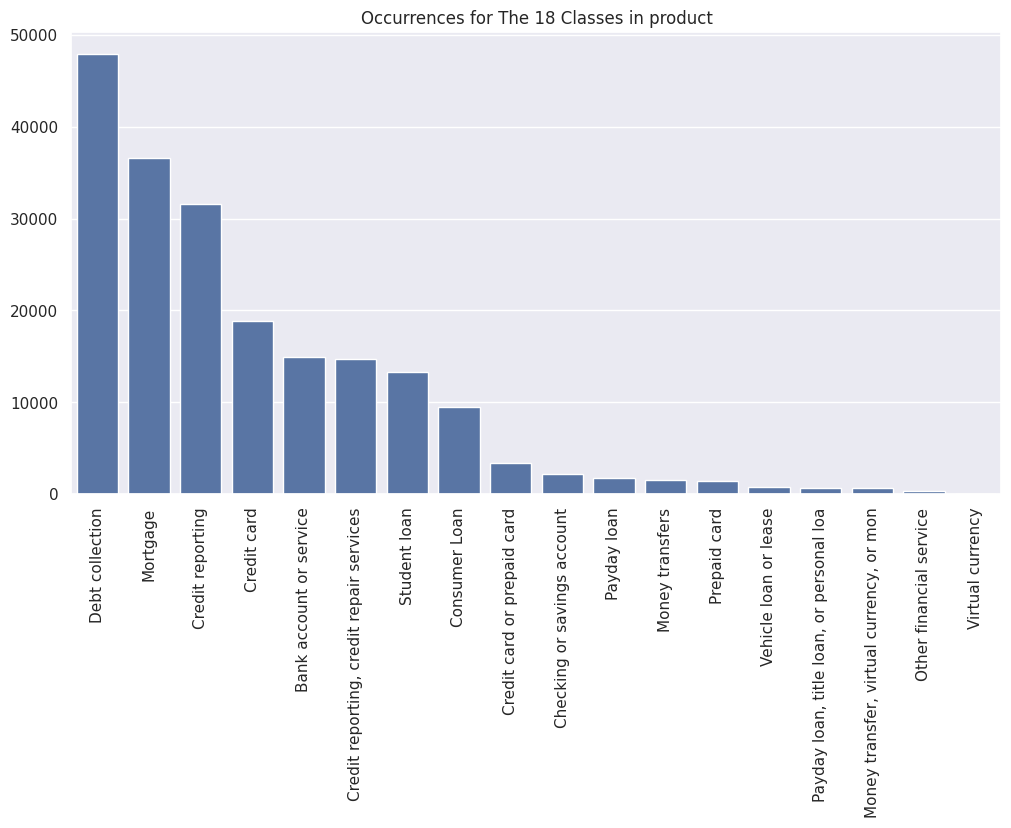

In [7]:
labels, counamts = frequencies(d, 'product')

Simplificamos o problema, considerando somente as 6 classes mais frequentes:

In [8]:
s = d['product'].isin(labels[:6])
d = d[s]

test_share = .3

d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

Vamos codificar as palavras na conversa utilizando o TF-IDF, gerando um vetor de características baseadas nas frequências de ocorrência das palavras no documento e em todo o conjunto de dados.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

## Treinando um regressor logístico para classificar produto
**Atividade (1 pt):** treine um regressor logístico, buscando os hiper-parâmetros com *grid-search*.

In [10]:

from sklearn.model_selection import GridSearchCV


C_range = np.logspace(-1, 1, 3)
print(C_range)

param_grid = dict(C=C_range)
print(param_grid)

model = LogisticRegression()

grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy',verbose=1, n_jobs = -1)

grid.fit(x_train, ye_train)



[ 0.1  1.  10. ]
{'C': array([ 0.1,  1. , 10. ])}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([ 0.1,  1. , 10. ])}, scoring='accuracy',
             verbose=1)

In [11]:
grid.cv_results_['mean_test_score']

array([0.81780916, 0.81772231, 0.81753993])

In [12]:
grid.cv_results_['params']

[{'C': np.float64(0.1)}, {'C': np.float64(1.0)}, {'C': np.float64(10.0)}]

In [13]:
grid.cv_results_

{'mean_fit_time': array([11.59662231, 12.26233888,  9.02910884]),
 'std_fit_time': array([2.78698945, 3.44685155, 2.32574298]),
 'mean_score_time': array([0.02837563, 0.0255723 , 0.01847251]),
 'std_score_time': array([0.01071554, 0.00597629, 0.00294635]),
 'param_C': masked_array(data=[0.1, 1.0, 10.0],
              mask=[False, False, False],
        fill_value=1e+20),
 'params': [{'C': np.float64(0.1)},
  {'C': np.float64(1.0)},
  {'C': np.float64(10.0)}],
 'split0_test_score': array([0.81954613, 0.81925953, 0.81936375]),
 'split1_test_score': array([0.82092702, 0.82121362, 0.82079675]),
 'split2_test_score': array([0.81295433, 0.81269378, 0.81245929]),
 'mean_test_score': array([0.81780916, 0.81772231, 0.81753993]),
 'std_test_score': array([0.00347887, 0.0036441 , 0.00363988]),
 'rank_test_score': array([1, 2, 3], dtype=int32)}

Iremos calcular a matriz de confusão relativa $R$, que guarda porcentagens de incidências em vez das contagens absolutas, e plotar o heatmap dessa matriz. Além disso, iremos calcular a distribuição de confiança nas predições por classe (mais próximos de `1.0` --> mais confiante):

In [14]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print('Accuracy:', round(metrics.accuracy_score(y, p)))
    print('Accuracy (balanced):', round(metrics.balanced_accuracy_score(y, p)))

    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)

    # Impressão dos gráficos.
    (plt
     .figure(figsize=(16, 12))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)

    (plt
     .figure(figsize=(16, 12))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))

    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        sns.distplot(probabilities[y.ravel() == i][:, i],
                     hist=False,
                     label=labels[i])
    plt.legend(labels=labels)

Vamos utilizar a função `evaluate` para avaliar o modelo treinado anteriormente:

Accuracy: 1
Accuracy (balanced): 1


<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: User

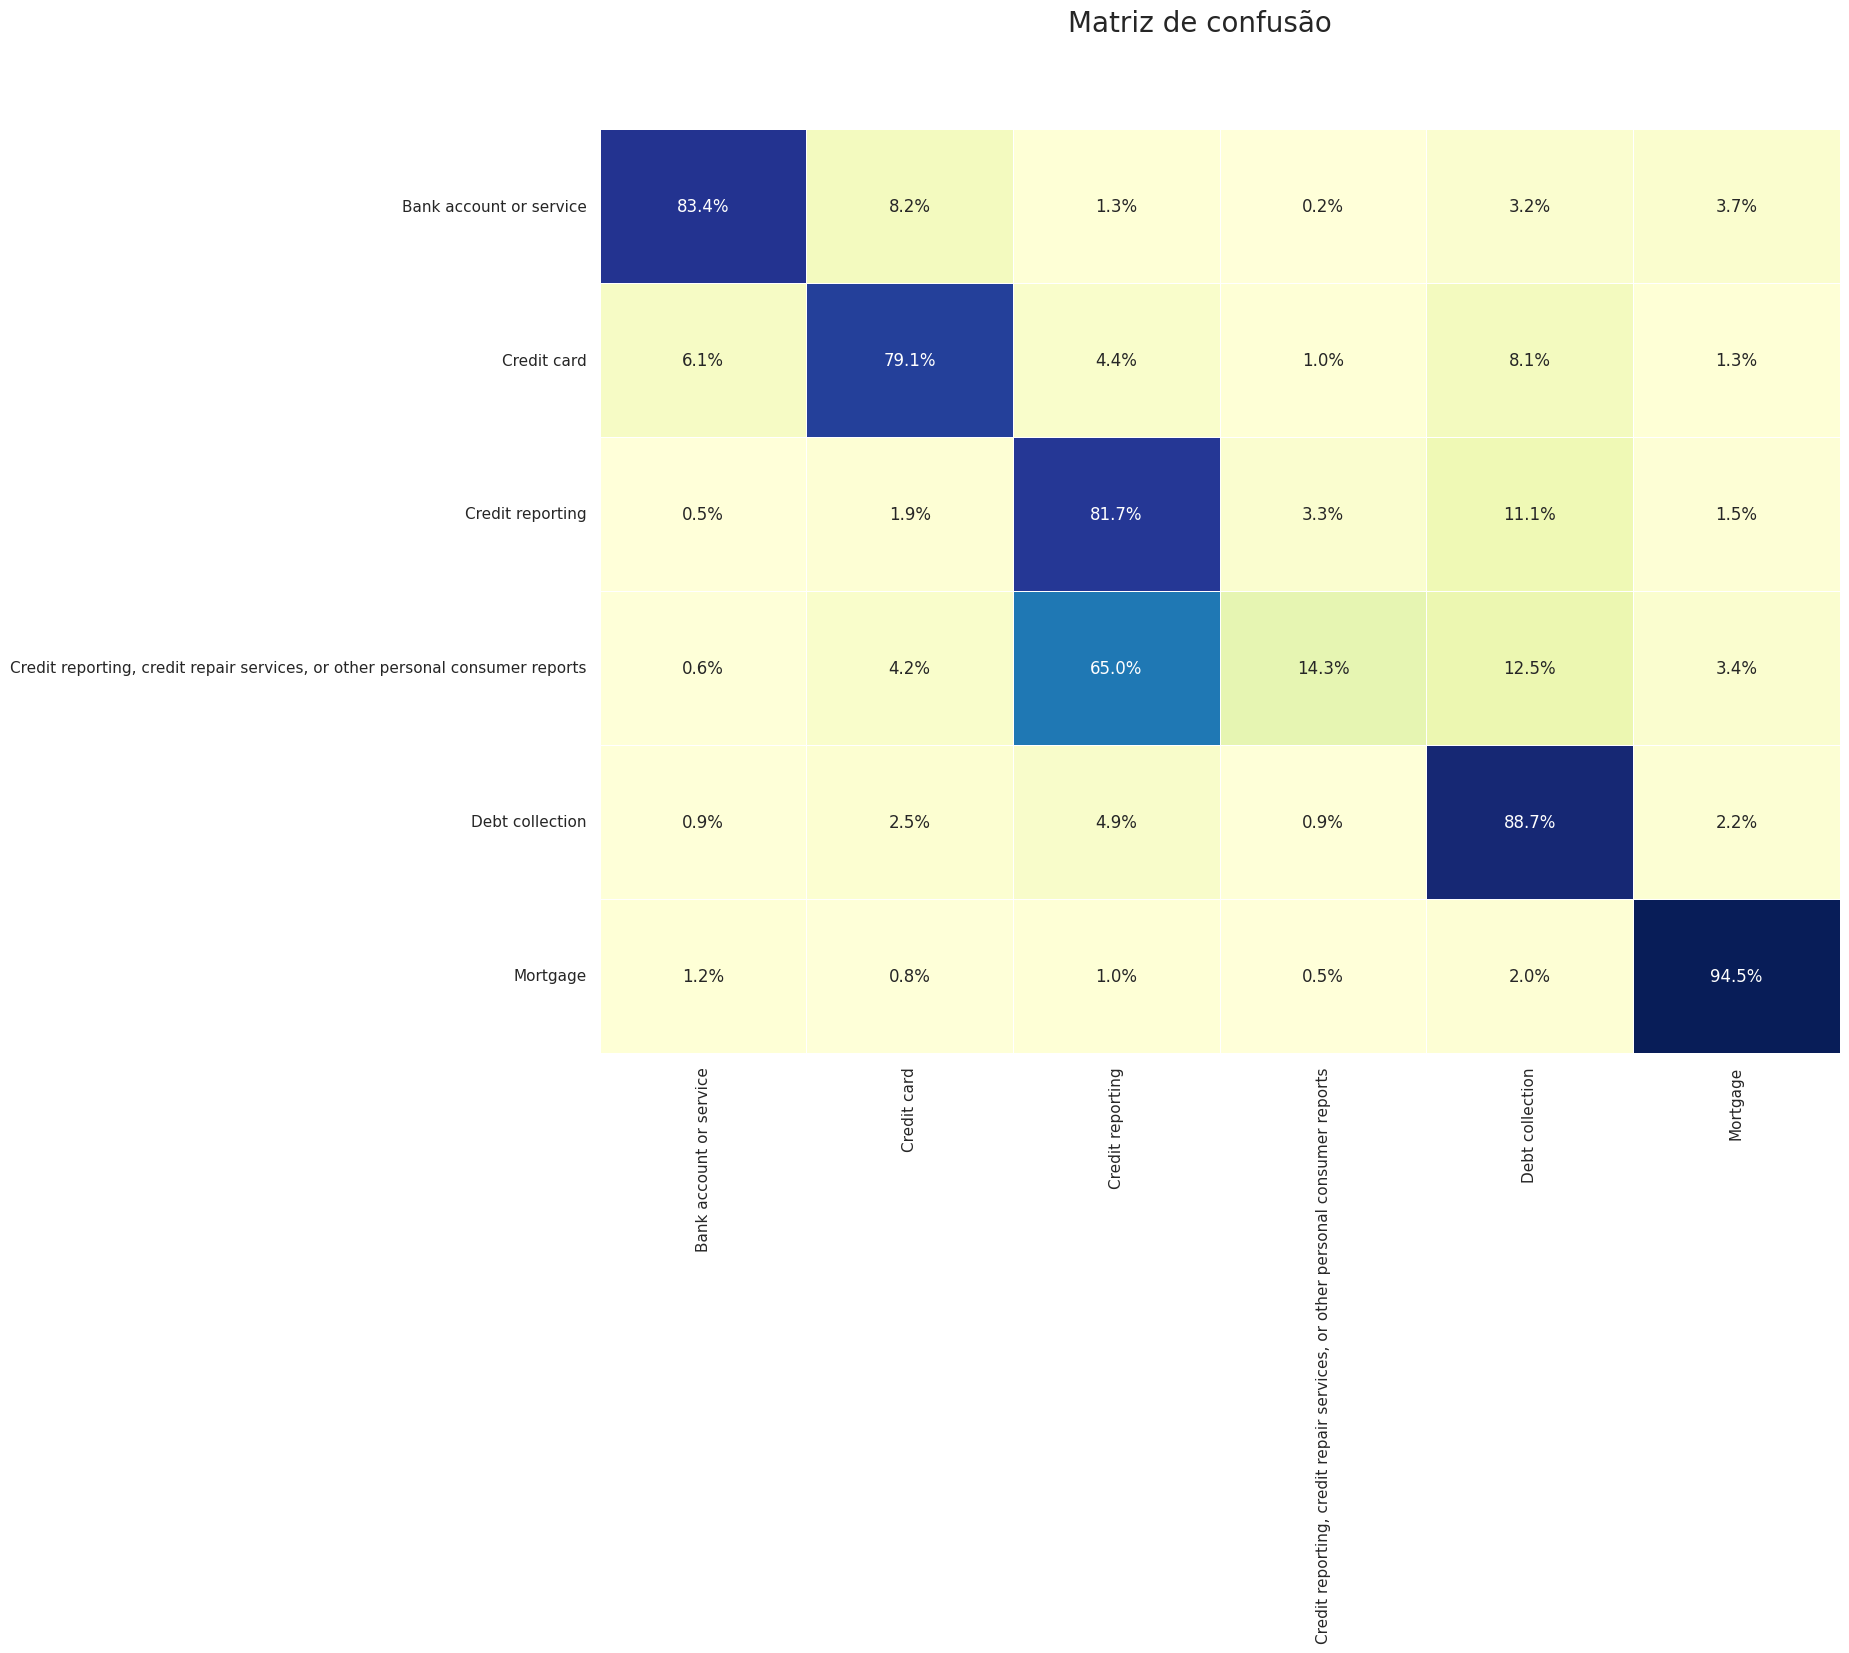

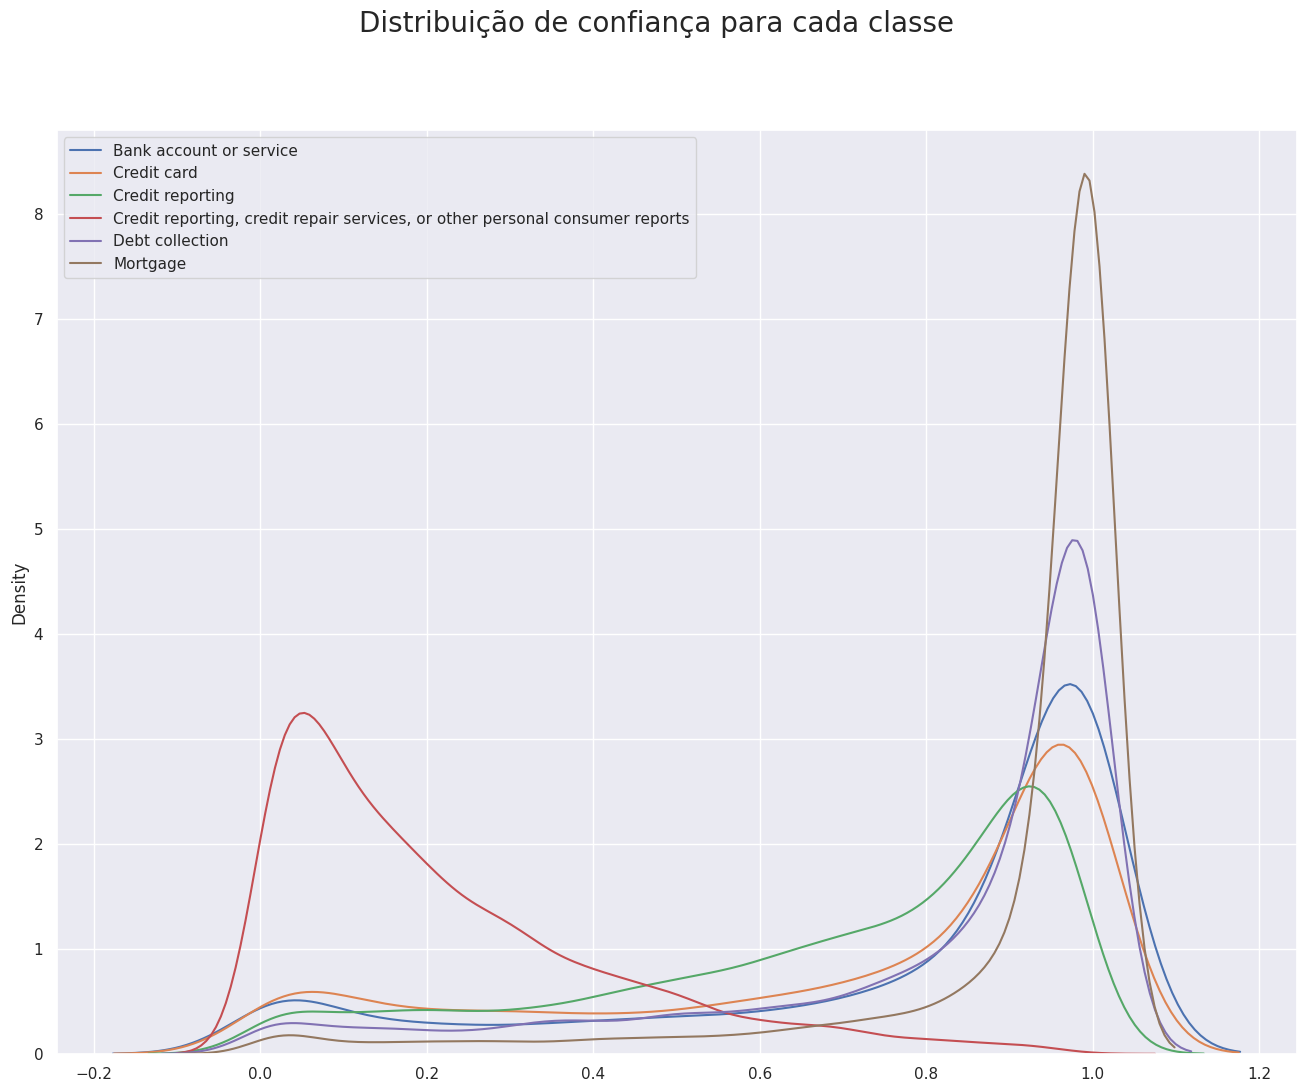

In [15]:
evaluate(ye_test, grid.predict(x_test), grid.predict_proba(x_test), labels=label_enc.classes_)

**Pergunta (1pt):** considerando o gráfico de distribuição de confiança para o seu modelo treinado, as amostras são classificadas com alta confiança? Há uma grande diferença de confiança entre as diferentes classes?

 A maioria das amostras é classificada com alta confiança, com distribuições concentradas próximas de 1.0 para.

 No entanto,  Credit reporting, credit repair services... apresenta baixa confiança, com muitas predições próximas de 0. Isso indica variação na segurança do modelo entre categorias.

 o desempenho mais baixo da classe "Credit reporting, credit repair services, or other personal consumer reports" se deve, em grande parte, à alta similaridade textual com a classe "Credit reporting".

 Ambas compartilham a mesma expressão inicial "Credit reporting", e como o modelo é baseado em TF-IDF (foco em palavras mais frequentes e discriminativas), ele tem dificuldade em diferenciar essas duas classes, pois os textos associados provavelmente contêm vocabulário muito semelhante.

----------
----------

## Redes Neurais
Iremos treinar alguns modelos de redes neurais, variando número de camadas e quantidade de neurônios em cada camada.

In [16]:
epochs = 3
batch_size = 128
input_shape = [features]

Vamos converter os rótulos em vetores *One Hot Encoded*:

In [17]:
from tensorflow.keras.utils import to_categorical

y_ohe_train = to_categorical(ye_train, num_classes=6)
y_ohe_test = to_categorical(ye_test, num_classes=6)

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema.

In [18]:
print("Number of features in x_train:", x_train.shape[1])
print("Number of classes in y_ohe_test:", y_ohe_test.shape[1])


Number of features in x_train: 1024
Number of classes in y_ohe_test: 6


In [19]:
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Activation, Input
from keras.utils import to_categorical
from keras import optimizers

ipt = Input(shape = (1024,))
x = Dense(512, activation='relu')(ipt)
y = Dense(512, activation='relu')(x)
out = Dense(6, activation='softmax')(y)

model = Model(inputs=ipt, outputs=out)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 790,534 (3.02 MB)

 Trainable params: 790,534 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

### Treinando a rede neural

**Atividade (1 pt):** treine o modelo definido acima sobre o conjunto, respeitando as seguintes regras:

1. Separe um subconjunto do treino para validação.
2. Utilize alguma técnica para conservar os parâmetros que melhor generalizam o problema, como `ModelCheckpoint` (salve o modelo com nome de `weights.h5`).

In [21]:
from sklearn.model_selection import train_test_split

x_train_nn, x_val_nn, y_ohe_train_nn, y_ohe_val_nn = train_test_split(
    x_train, y_ohe_train, test_size=0.2, random_state=42
)

print(x_val_nn.shape)
print(y_ohe_val_nn.shape)
print(x_train_nn.shape)
print(y_ohe_train_nn.shape)

(23029, 1024)
(23029, 6)
(92114, 1024)
(92114, 6)


In [22]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("weights.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model.fit(x_train_nn, y_ohe_train_nn,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=(x_val_nn, y_ohe_val_nn),
                    callbacks=[checkpoint])


Epoch 1/10
716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5671 - loss: 1.1946
Epoch 1: val_loss improved from inf to 0.65101, saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.5680 - loss: 1.1926 - val_accuracy: 0.7800 - val_loss: 0.6510
Epoch 2/10
718/720 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7985 - loss: 0.6006
Epoch 2: val_loss improved from 0.65101 to 0.58267, saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.7986 - loss: 0.6005 - val_accuracy: 0.8048 - val_loss: 0.5827
Epoch 3/10
718/720 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8221 - loss: 0.5277
Epoch 3: val_loss improved from 0.58267 to 0.55581, saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.8221 - loss: 0.5276 - val_accuracy: 0.8128 - val_loss: 0.5558
Epoch 4/10
718/720 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8355 - loss: 0.4875
Epoch 4: val_loss improved from 0.55581 to 0.54047, saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8355 - loss: 0.4874 - val_accuracy: 0.8182 - val_loss: 0.5405
Epoch 5/10
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8481 - loss: 0.4538
Epoch 5: val_loss improved from 0.54047 to 0.53192, saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8481 - loss: 0.4538 - val_accuracy: 0.8225 - val_loss: 0.5319
Epoch 6/10
716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8580 - loss: 0.4325
Epoch 6: val_loss improved from 0.53192 to 0.52499, saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8580 - loss: 0.4325 - val_accuracy: 0.8268 - val_loss: 0.5250
Epoch 7/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8648 - loss: 0.4117
Epoch 7: val_loss improved from 0.52499 to 0.52386, saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8648 - loss: 0.4117 - val_accuracy: 0.8271 - val_loss: 0.5239
Epoch 8/10
719/720 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8734 - loss: 0.3872
Epoch 8: val_loss improved from 0.52386 to 0.51877, saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8734 - loss: 0.3872 - val_accuracy: 0.8293 - val_loss: 0.5188
Epoch 9/10
718/720 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8817 - loss: 0.3710
Epoch 9: val_loss improved from 0.51877 to 0.51715, saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8817 - loss: 0.3710 - val_accuracy: 0.8313 - val_loss: 0.5172
Epoch 10/10
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8861 - loss: 0.3534
Epoch 10: val_loss did not improve from 0.51715
720/720 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8861 - loss: 0.3534 - val_accuracy: 0.8312 - val_loss: 0.5182


In [23]:
model.load_weights('weights.h5')

O método `model.fit` retorna `model.history`, e contem algumas informações interessantes a respeito do histórico de treinamento.

**Atividade (1 pt):** plote um gráfico de linhas exibindo a evolução dos valores da função *loss* sobre o conjunto de treino e validação. A partir de qual `epoch` a rede começou a super-especializar?

In [24]:
history_f = pd.DataFrame(model.history.history)
history_f.head()

,accuracy,loss,val_accuracy,val_loss
0,0.689179,0.910013,0.779973,0.651006
1,0.804156,0.584265,0.804768,0.582669
2,0.825314,0.522009,0.812845,0.555808
3,0.837278,0.484892,0.818229,0.540468
4,0.847363,0.456689,0.822528,0.531923


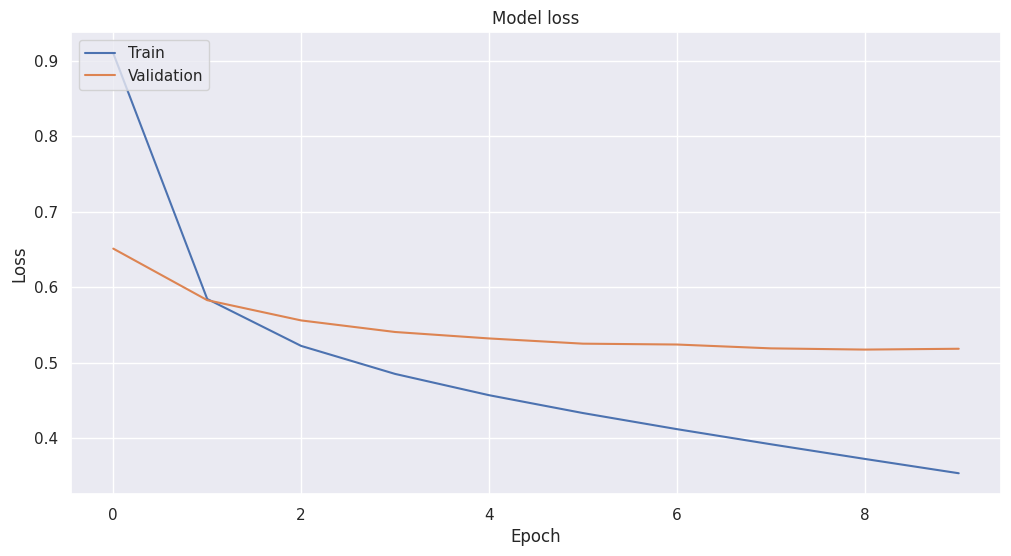

In [25]:
history_f = pd.DataFrame(model.history.history)
history_f.head()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Avaliando o modelo treinado

**Atividade (1 pt):** teste o modelo treinado utilizando o subconjunto de teste. Reporte a acurácia para cada classe e a matriz de confusão percentual (usando a função `evaluate` definida anteriormente).

1543/1543 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Accuracy: 1
Accuracy (balanced): 1


<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: User

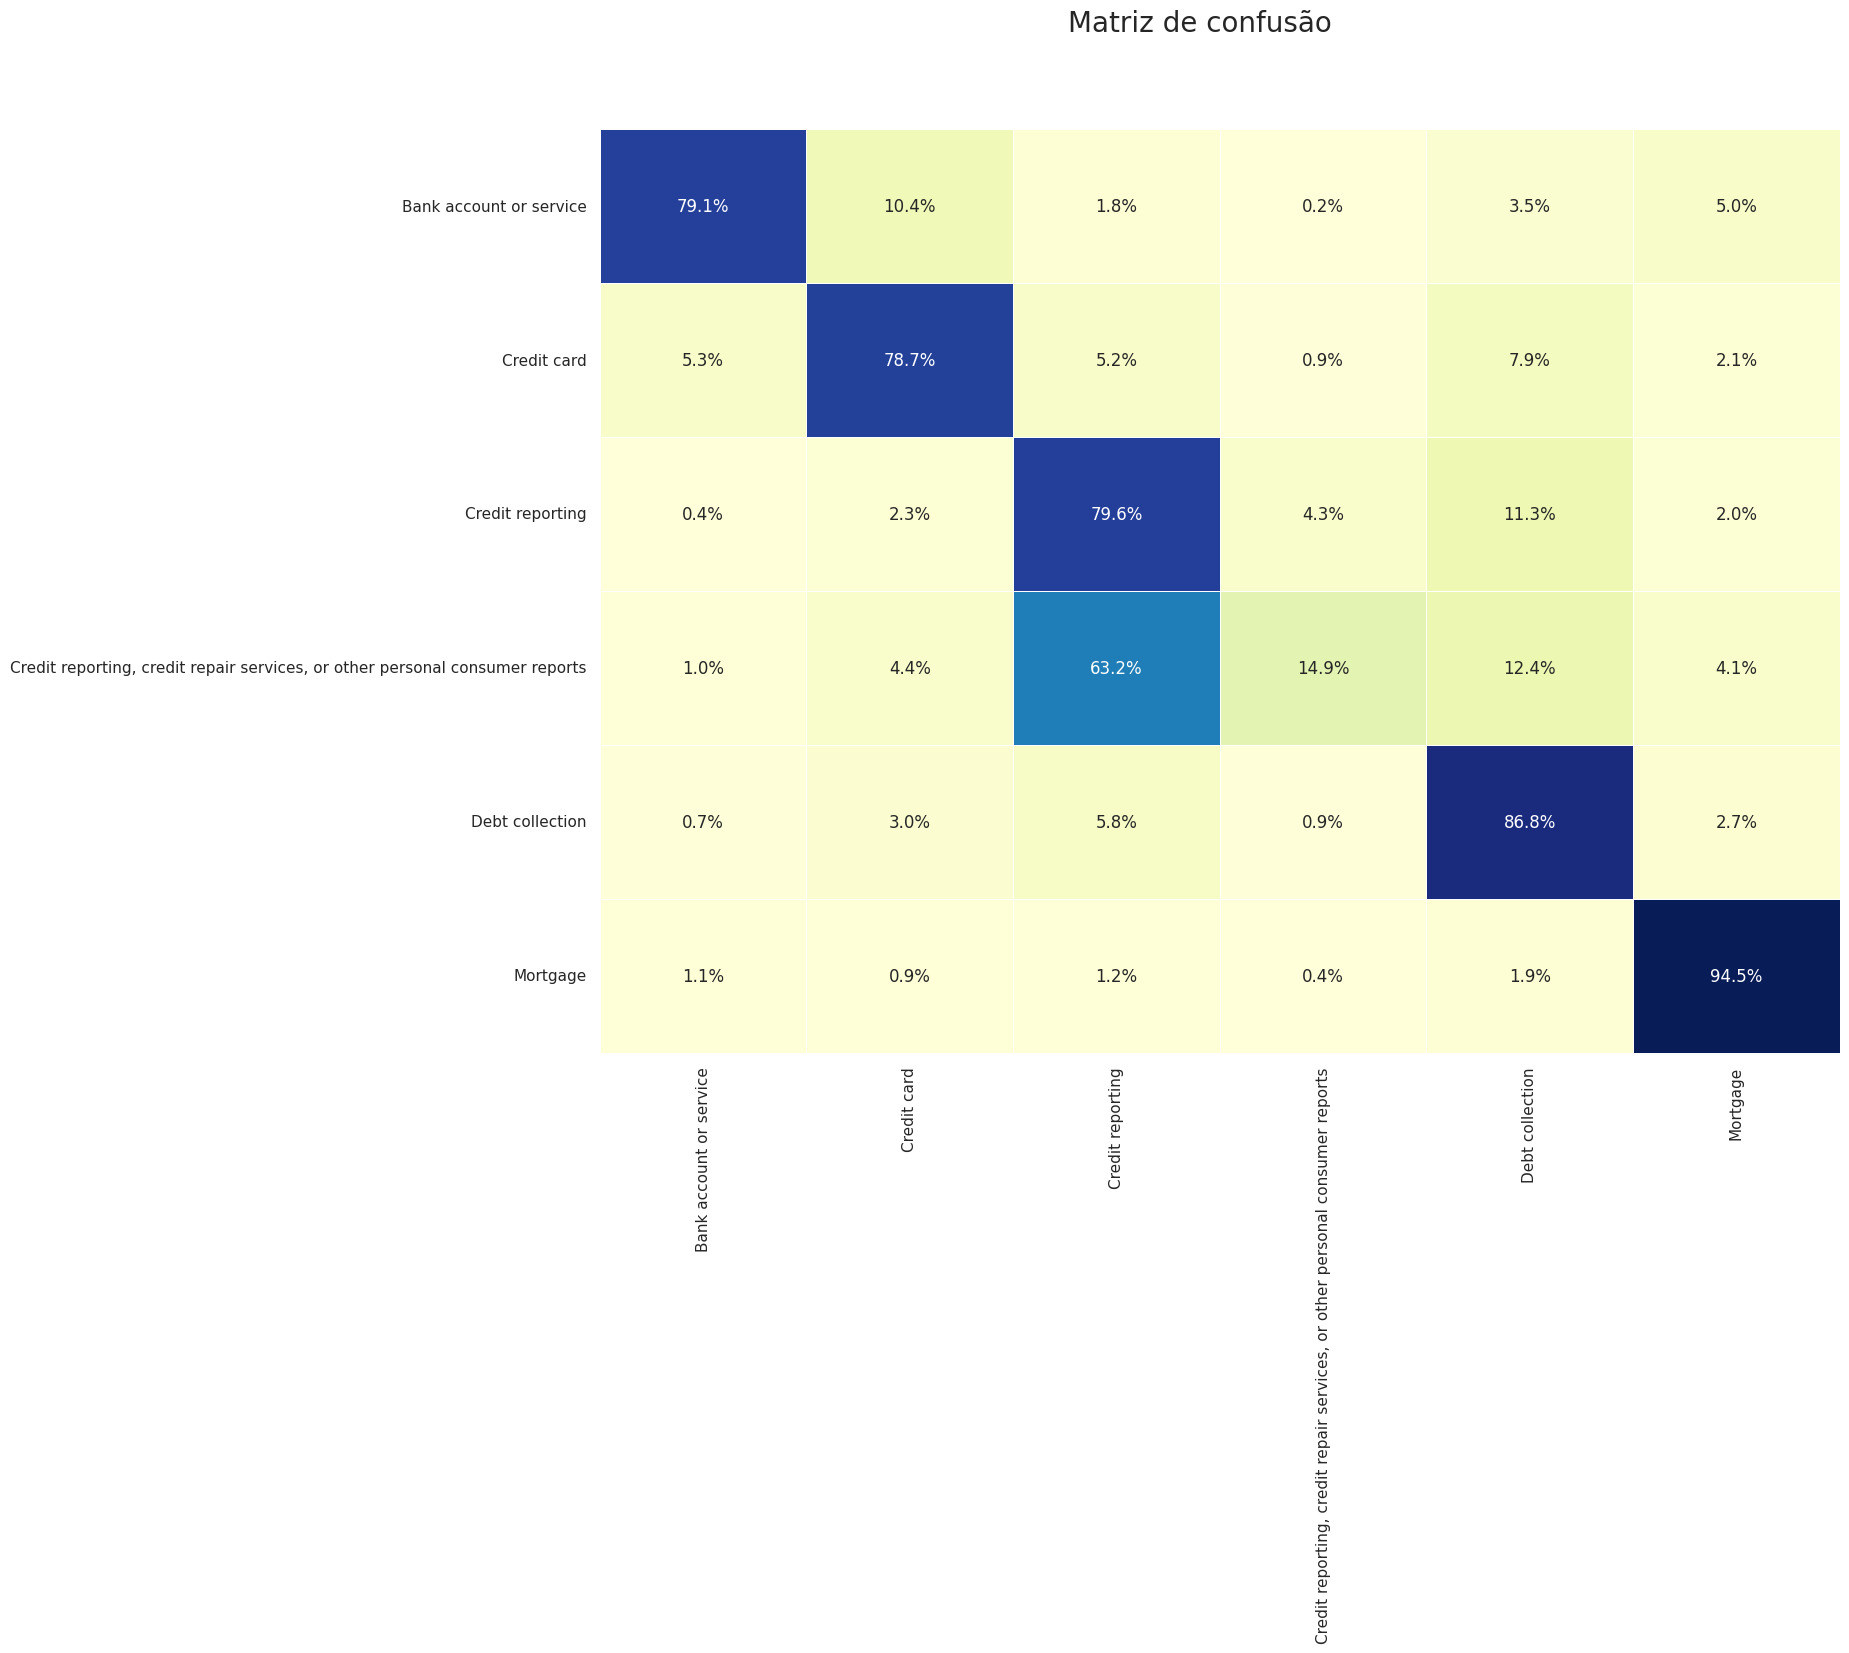

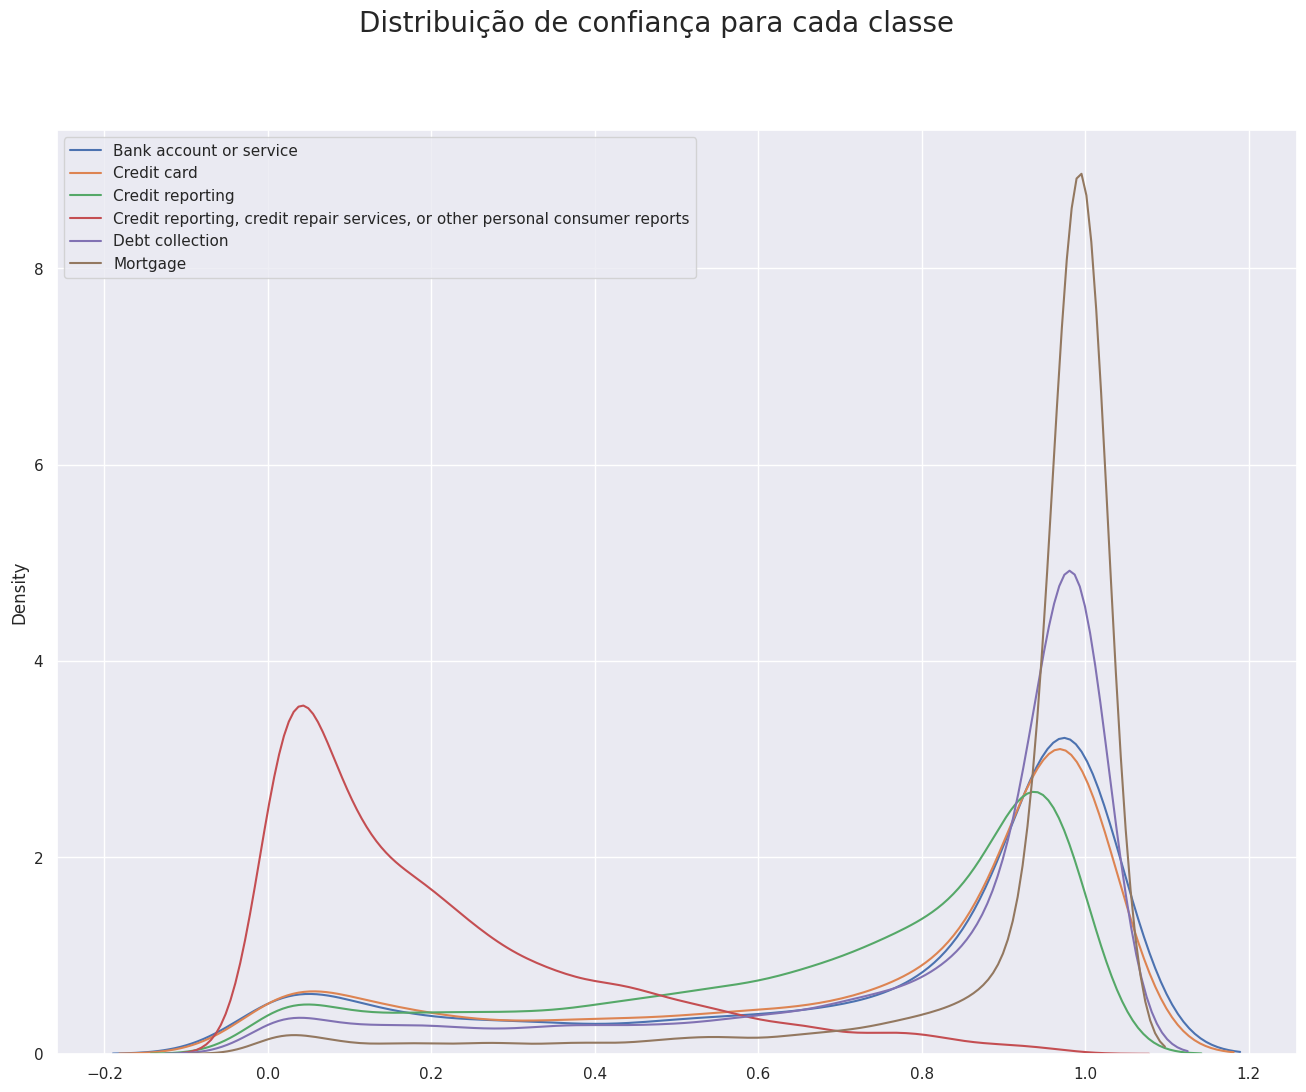

In [26]:
y_pred_probs = model.predict(x_test)

y_pred_nn = np.argmax(y_pred_probs, axis=1)

evaluate(ye_test, y_pred_nn, y_pred_probs, labels=label_enc.classes_)


--------

Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

In [27]:
ipt = Input(shape = (1024,))
x = Dense(1024, activation='relu')(ipt)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
out = Dense(6, activation='softmax')(x)

model_complex = Model(inputs=ipt, outputs=out)
model_complex.summary()
model_complex.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627,078 (10.02 MB)

 Trainable params: 2,627,078 (10.02 MB)

 Non-trainable params: 0 (0.00 B)

**Atividade (1 pt):** treine a nova rede.

In [28]:

checkpoint_complex = ModelCheckpoint("weights_complex.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history_complex = model_complex.fit(x_train_nn, y_ohe_train_nn,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=(x_val_nn, y_ohe_val_nn),
                    callbacks=[checkpoint_complex])

model_complex.load_weights('weights_complex.h5')


Epoch 1/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5855 - loss: 1.1495
Epoch 1: val_loss improved from inf to 0.62205, saving model to weights_complex.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 47s 64ms/step - accuracy: 0.5856 - loss: 1.1491 - val_accuracy: 0.7905 - val_loss: 0.6221
Epoch 2/10
719/720 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8079 - loss: 0.5692
Epoch 2: val_loss improved from 0.62205 to 0.56631, saving model to weights_complex.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.8079 - loss: 0.5691 - val_accuracy: 0.8107 - val_loss: 0.5663
Epoch 3/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8346 - loss: 0.4894
Epoch 3: val_loss improved from 0.56631 to 0.53625, saving model to weights_complex.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 79s 63ms/step - accuracy: 0.8346 - loss: 0.4894 - val_accuracy: 0.8215 - val_loss: 0.5362
Epoch 4/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8511 - loss: 0.4465
Epoch 4: val_loss improved from 0.53625 to 0.53257, saving model to weights_complex.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 83s 64ms/step - accuracy: 0.8511 - loss: 0.4465 - val_accuracy: 0.8208 - val_loss: 0.5326
Epoch 5/10
719/720 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8650 - loss: 0.4110
Epoch 5: val_loss improved from 0.53257 to 0.52526, saving model to weights_complex.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 50s 69ms/step - accuracy: 0.8650 - loss: 0.4110 - val_accuracy: 0.8242 - val_loss: 0.5253
Epoch 6/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8752 - loss: 0.3799
Epoch 6: val_loss improved from 0.52526 to 0.51420, saving model to weights_complex.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 79s 65ms/step - accuracy: 0.8752 - loss: 0.3799 - val_accuracy: 0.8310 - val_loss: 0.5142
Epoch 7/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8883 - loss: 0.3456
Epoch 7: val_loss improved from 0.51420 to 0.51079, saving model to weights_complex.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 77s 58ms/step - accuracy: 0.8883 - loss: 0.3456 - val_accuracy: 0.8349 - val_loss: 0.5108
Epoch 8/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9013 - loss: 0.3162
Epoch 8: val_loss did not improve from 0.51079
720/720 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.9013 - loss: 0.3162 - val_accuracy: 0.8314 - val_loss: 0.5161
Epoch 9/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9112 - loss: 0.2822
Epoch 9: val_loss did not improve from 0.51079
720/720 ━━━━━━━━━━━━━━━━━━━━ 45s 62ms/step - accuracy: 0.9112 - loss: 0.2822 - val_accuracy: 0.8385 - val_loss: 0.5125
Epoch 10/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9262 - loss: 0.2491
Epoch 10: val_loss did not improve from 0.51079
720/720 ━━━━━━━━━━━━━━━━━━━━ 79s 58ms/step - accuracy: 0.9262 - loss: 0.2491 - val_accuracy: 0.8398 - val_loss: 0.5185


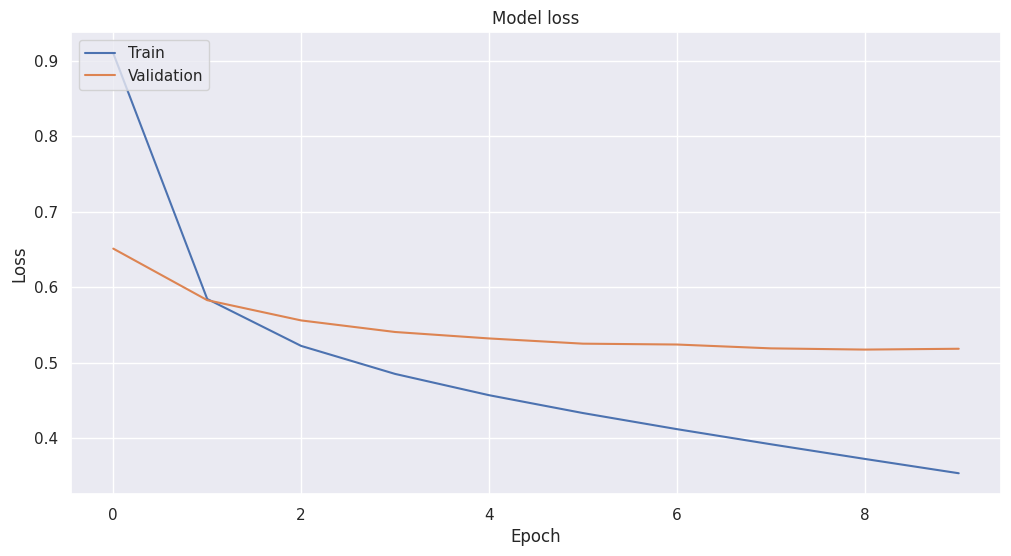

In [29]:
history_f = pd.DataFrame(model.history.history)
history_f.head()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1543/1543 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Accuracy: 1
Accuracy (balanced): 1


<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: User

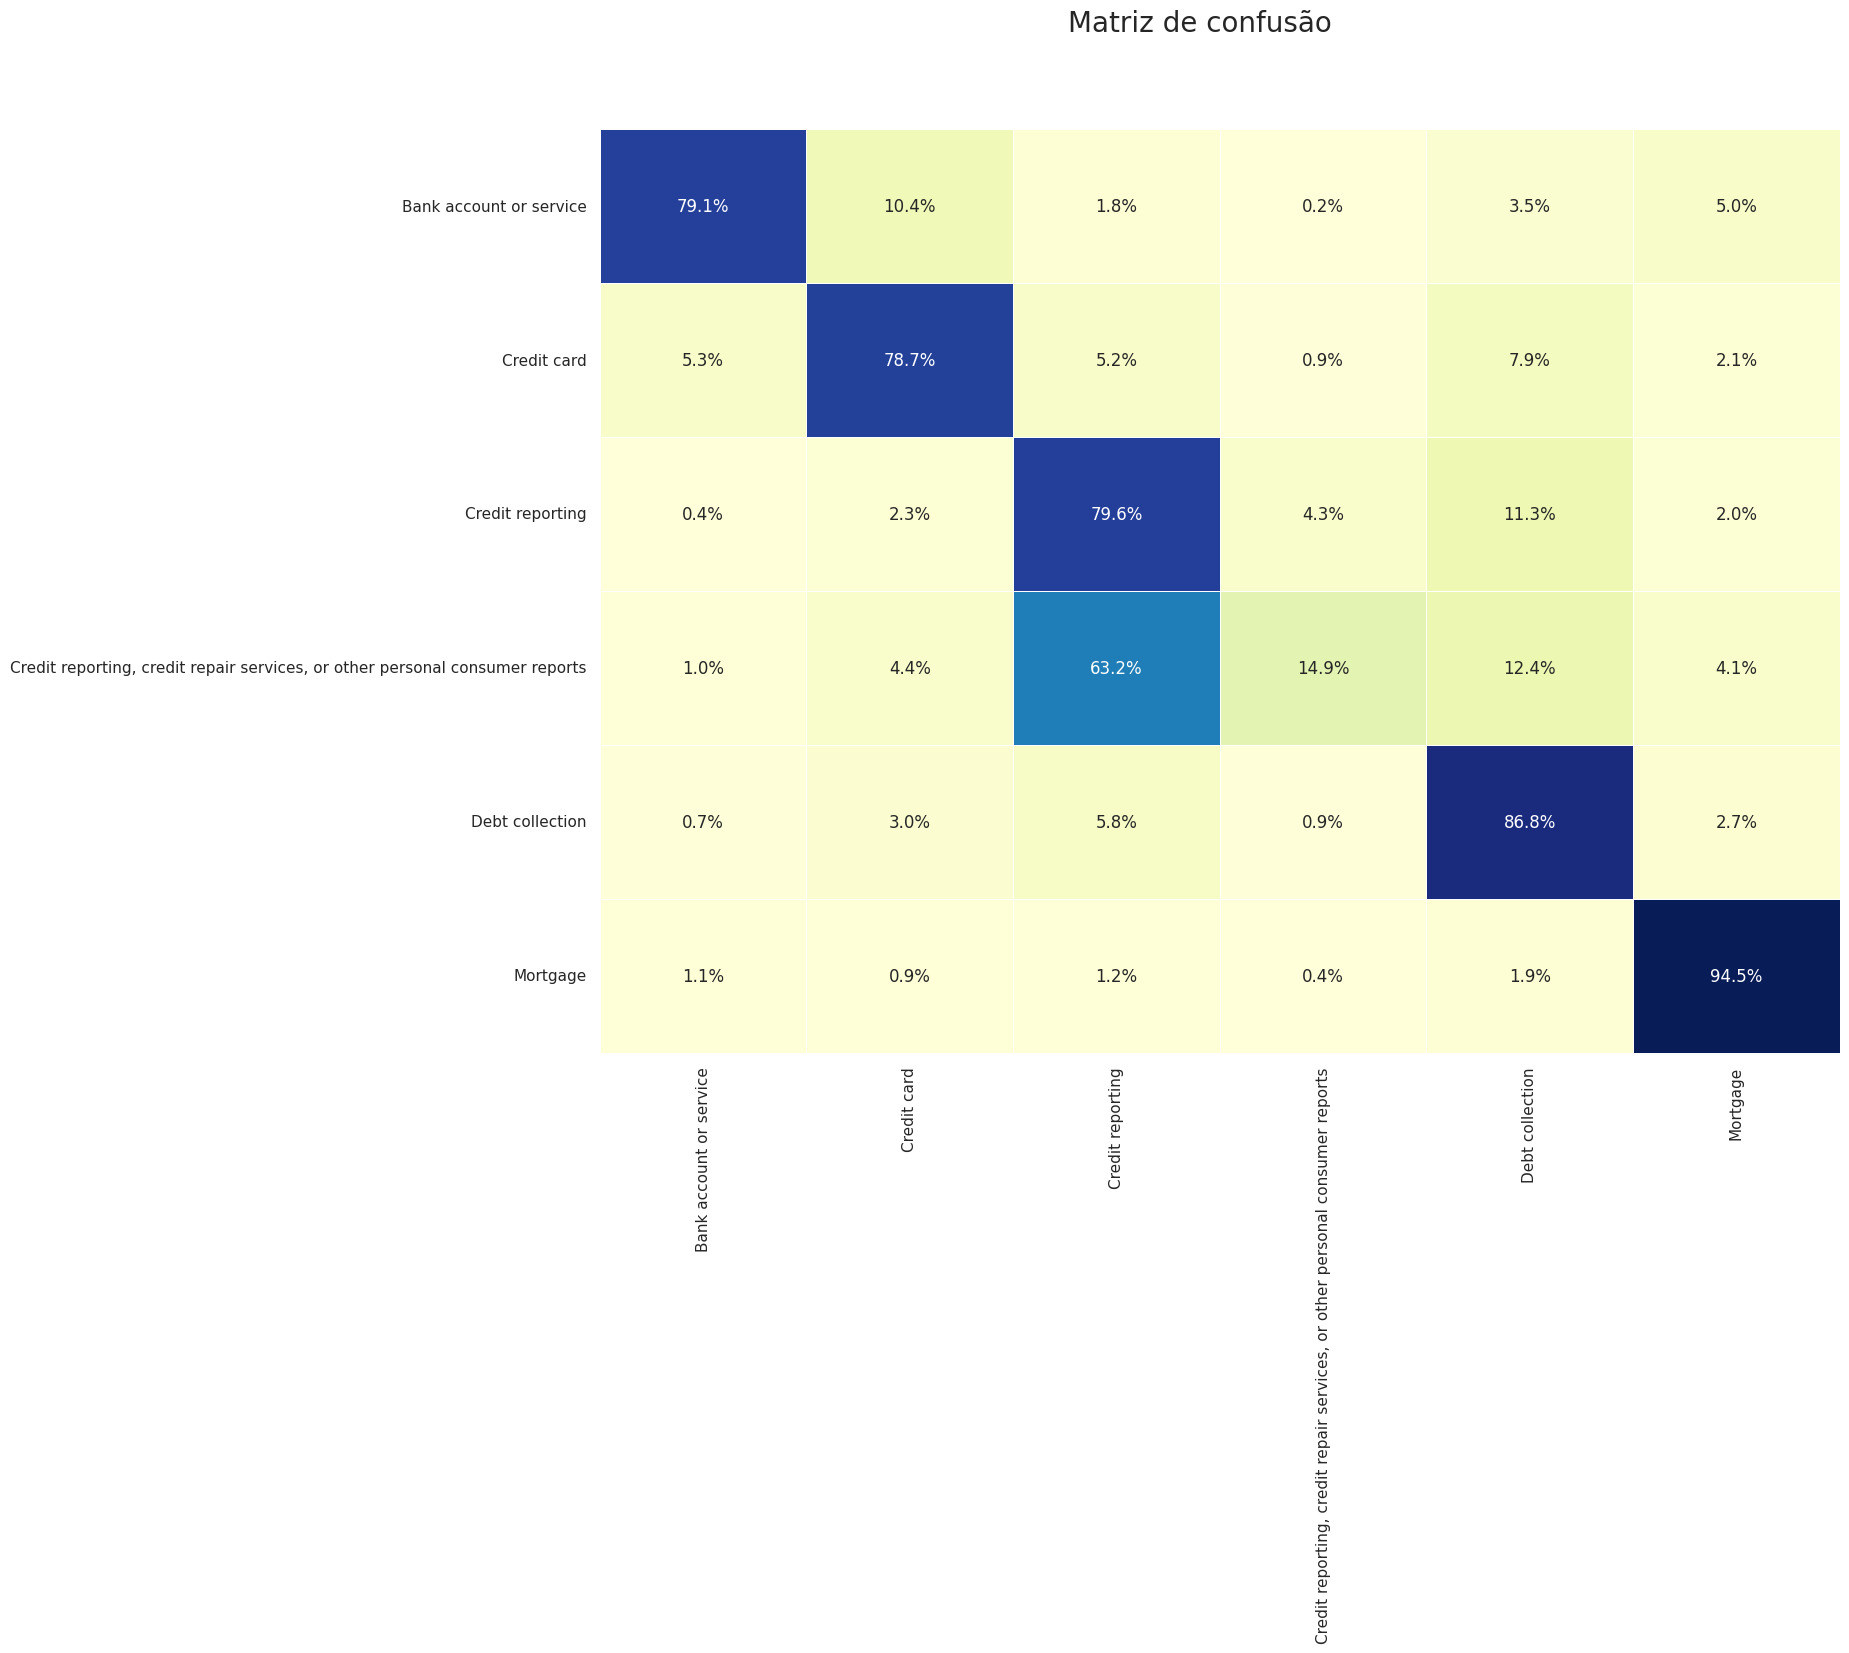

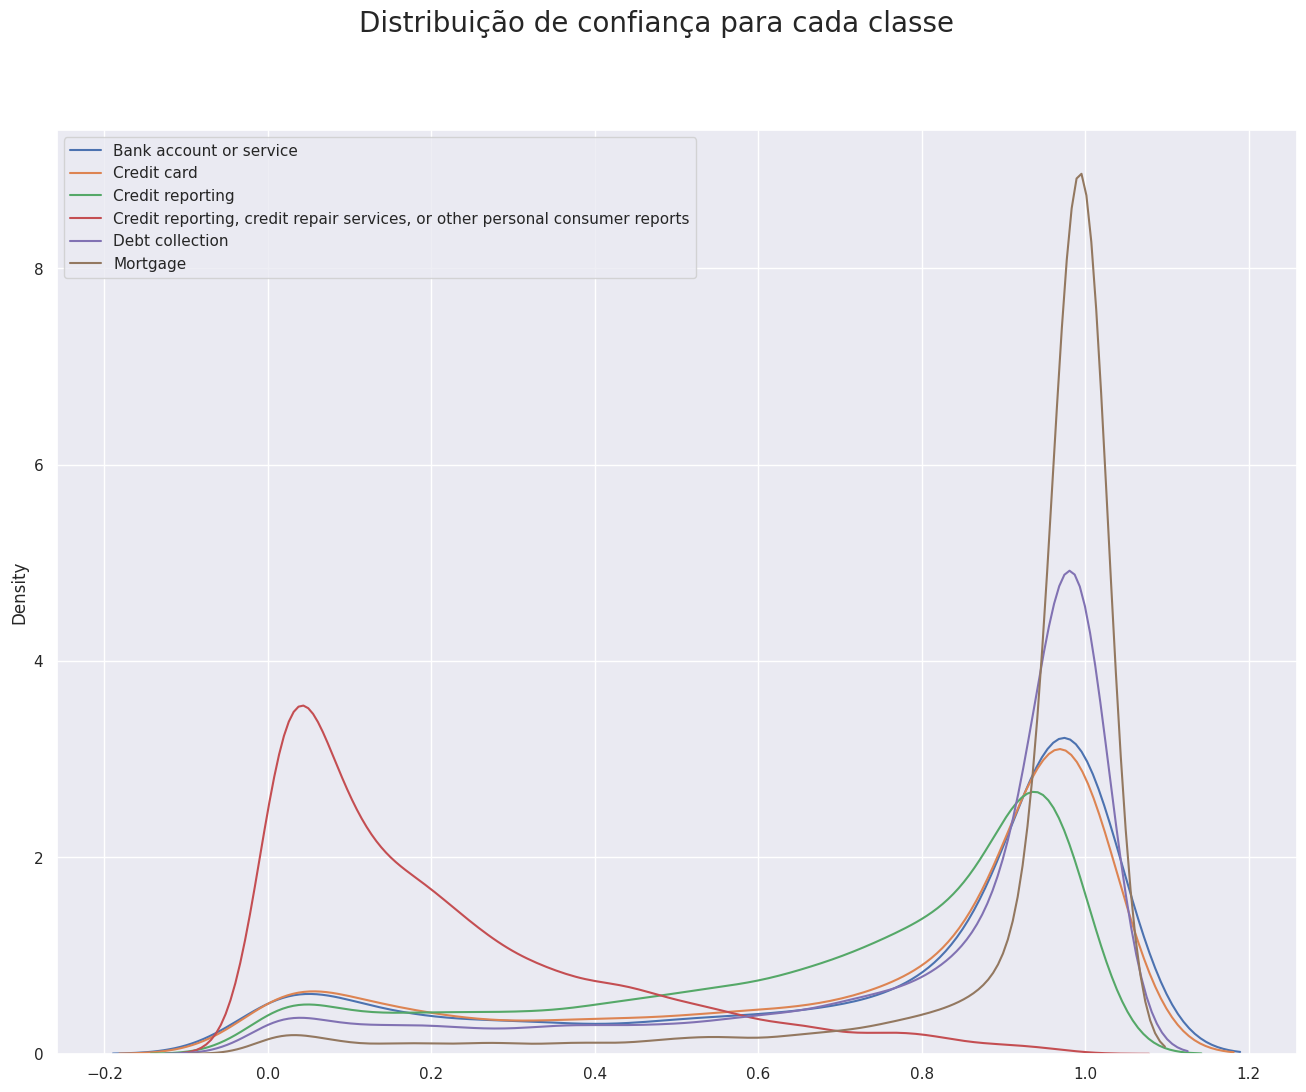

In [30]:
y_pred_probs = model.predict(x_test)

y_pred_nn = np.argmax(y_pred_probs, axis=1)

evaluate(ye_test, y_pred_nn, y_pred_probs, labels=label_enc.classes_)


**Atividade (1 pt):** adicione dropout ou regularização L1/L2 e treine o novo modelo. Se for, preciso, faça uma busca pelos hipeparâmetros da regularização/dropout.

In [31]:
import numpy as np
from keras.layers import Dropout
from keras.regularizers import l2

ipt = Input(shape=(1024,))
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(ipt)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
out = Dense(6, activation='softmax')(x)

model_regularized = Model(inputs=ipt, outputs=out)
model_regularized.summary()

model_regularized.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627,078 (10.02 MB)

 Trainable params: 2,627,078 (10.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4129 - loss: 26.9830
Epoch 1: val_loss improved from inf to 21.18480, saving model to weights_regularized.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 55s 75ms/step - accuracy: 0.4131 - loss: 26.9803 - val_accuracy: 0.7750 - val_loss: 21.1848
Epoch 2/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7141 - loss: 19.9392
Epoch 2: val_loss improved from 21.18480 to 15.97921, saving model to weights_regularized.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 83s 76ms/step - accuracy: 0.7141 - loss: 19.9374 - val_accuracy: 0.8009 - val_loss: 15.9792
Epoch 3/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7669 - loss: 15.0419
Epoch 3: val_loss improved from 15.97921 to 12.11699, saving model to weights_regularized.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 94s 93ms/step - accuracy: 0.7669 - loss: 15.0405 - val_accuracy: 0.8095 - val_loss: 12.1170
Epoch 4/10
719/720 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7861 - loss: 11.4164
Epoch 4: val_loss improved from 12.11699 to 9.23118, saving model to weights_regularized.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 68s 73ms/step - accuracy: 0.7861 - loss: 11.4143 - val_accuracy: 0.8160 - val_loss: 9.2312
Epoch 5/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8014 - loss: 8.6979
Epoch 5: val_loss improved from 9.23118 to 7.07068, saving model to weights_regularized.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 98s 95ms/step - accuracy: 0.8014 - loss: 8.6972 - val_accuracy: 0.8195 - val_loss: 7.0707
Epoch 6/10
719/720 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8117 - loss: 6.6693
Epoch 6: val_loss improved from 7.07068 to 5.45289, saving model to weights_regularized.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 65s 71ms/step - accuracy: 0.8117 - loss: 6.6681 - val_accuracy: 0.8236 - val_loss: 5.4529
Epoch 7/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8191 - loss: 5.1416
Epoch 7: val_loss improved from 5.45289 to 4.24150, saving model to weights_regularized.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - accuracy: 0.8191 - loss: 5.1412 - val_accuracy: 0.8242 - val_loss: 4.2415
Epoch 8/10
719/720 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8233 - loss: 4.0052
Epoch 8: val_loss improved from 4.24150 to 3.33561, saving model to weights_regularized.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 53s 73ms/step - accuracy: 0.8233 - loss: 4.0046 - val_accuracy: 0.8270 - val_loss: 3.3356
Epoch 9/10
719/720 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8265 - loss: 3.1544
Epoch 9: val_loss improved from 3.33561 to 2.65796, saving model to weights_regularized.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 54s 76ms/step - accuracy: 0.8265 - loss: 3.1539 - val_accuracy: 0.8277 - val_loss: 2.6580
Epoch 10/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8297 - loss: 2.5138
Epoch 10: val_loss improved from 2.65796 to 2.15104, saving model to weights_regularized.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - accuracy: 0.8297 - loss: 2.5137 - val_accuracy: 0.8292 - val_loss: 2.1510


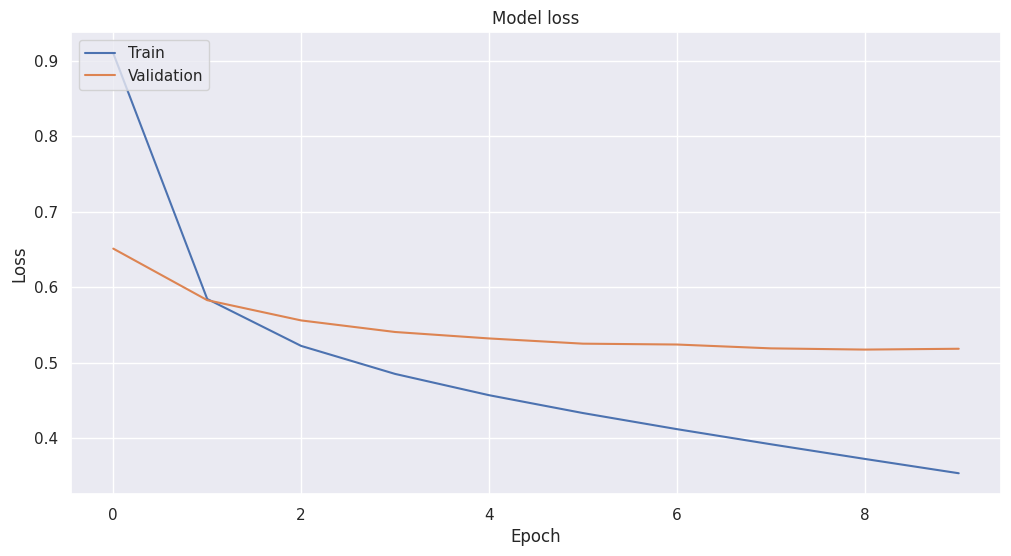

In [32]:
checkpoint_regularized = ModelCheckpoint("weights_regularized.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history_regularized = model_regularized.fit(x_train_nn, y_ohe_train_nn,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=(x_val_nn, y_ohe_val_nn),
                    callbacks=[checkpoint_regularized])

model_regularized.load_weights('weights_regularized.h5')

history_f = pd.DataFrame(model.history.history)
history_f.head()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1543/1543 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Accuracy: 1
Accuracy (balanced): 1


<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: User

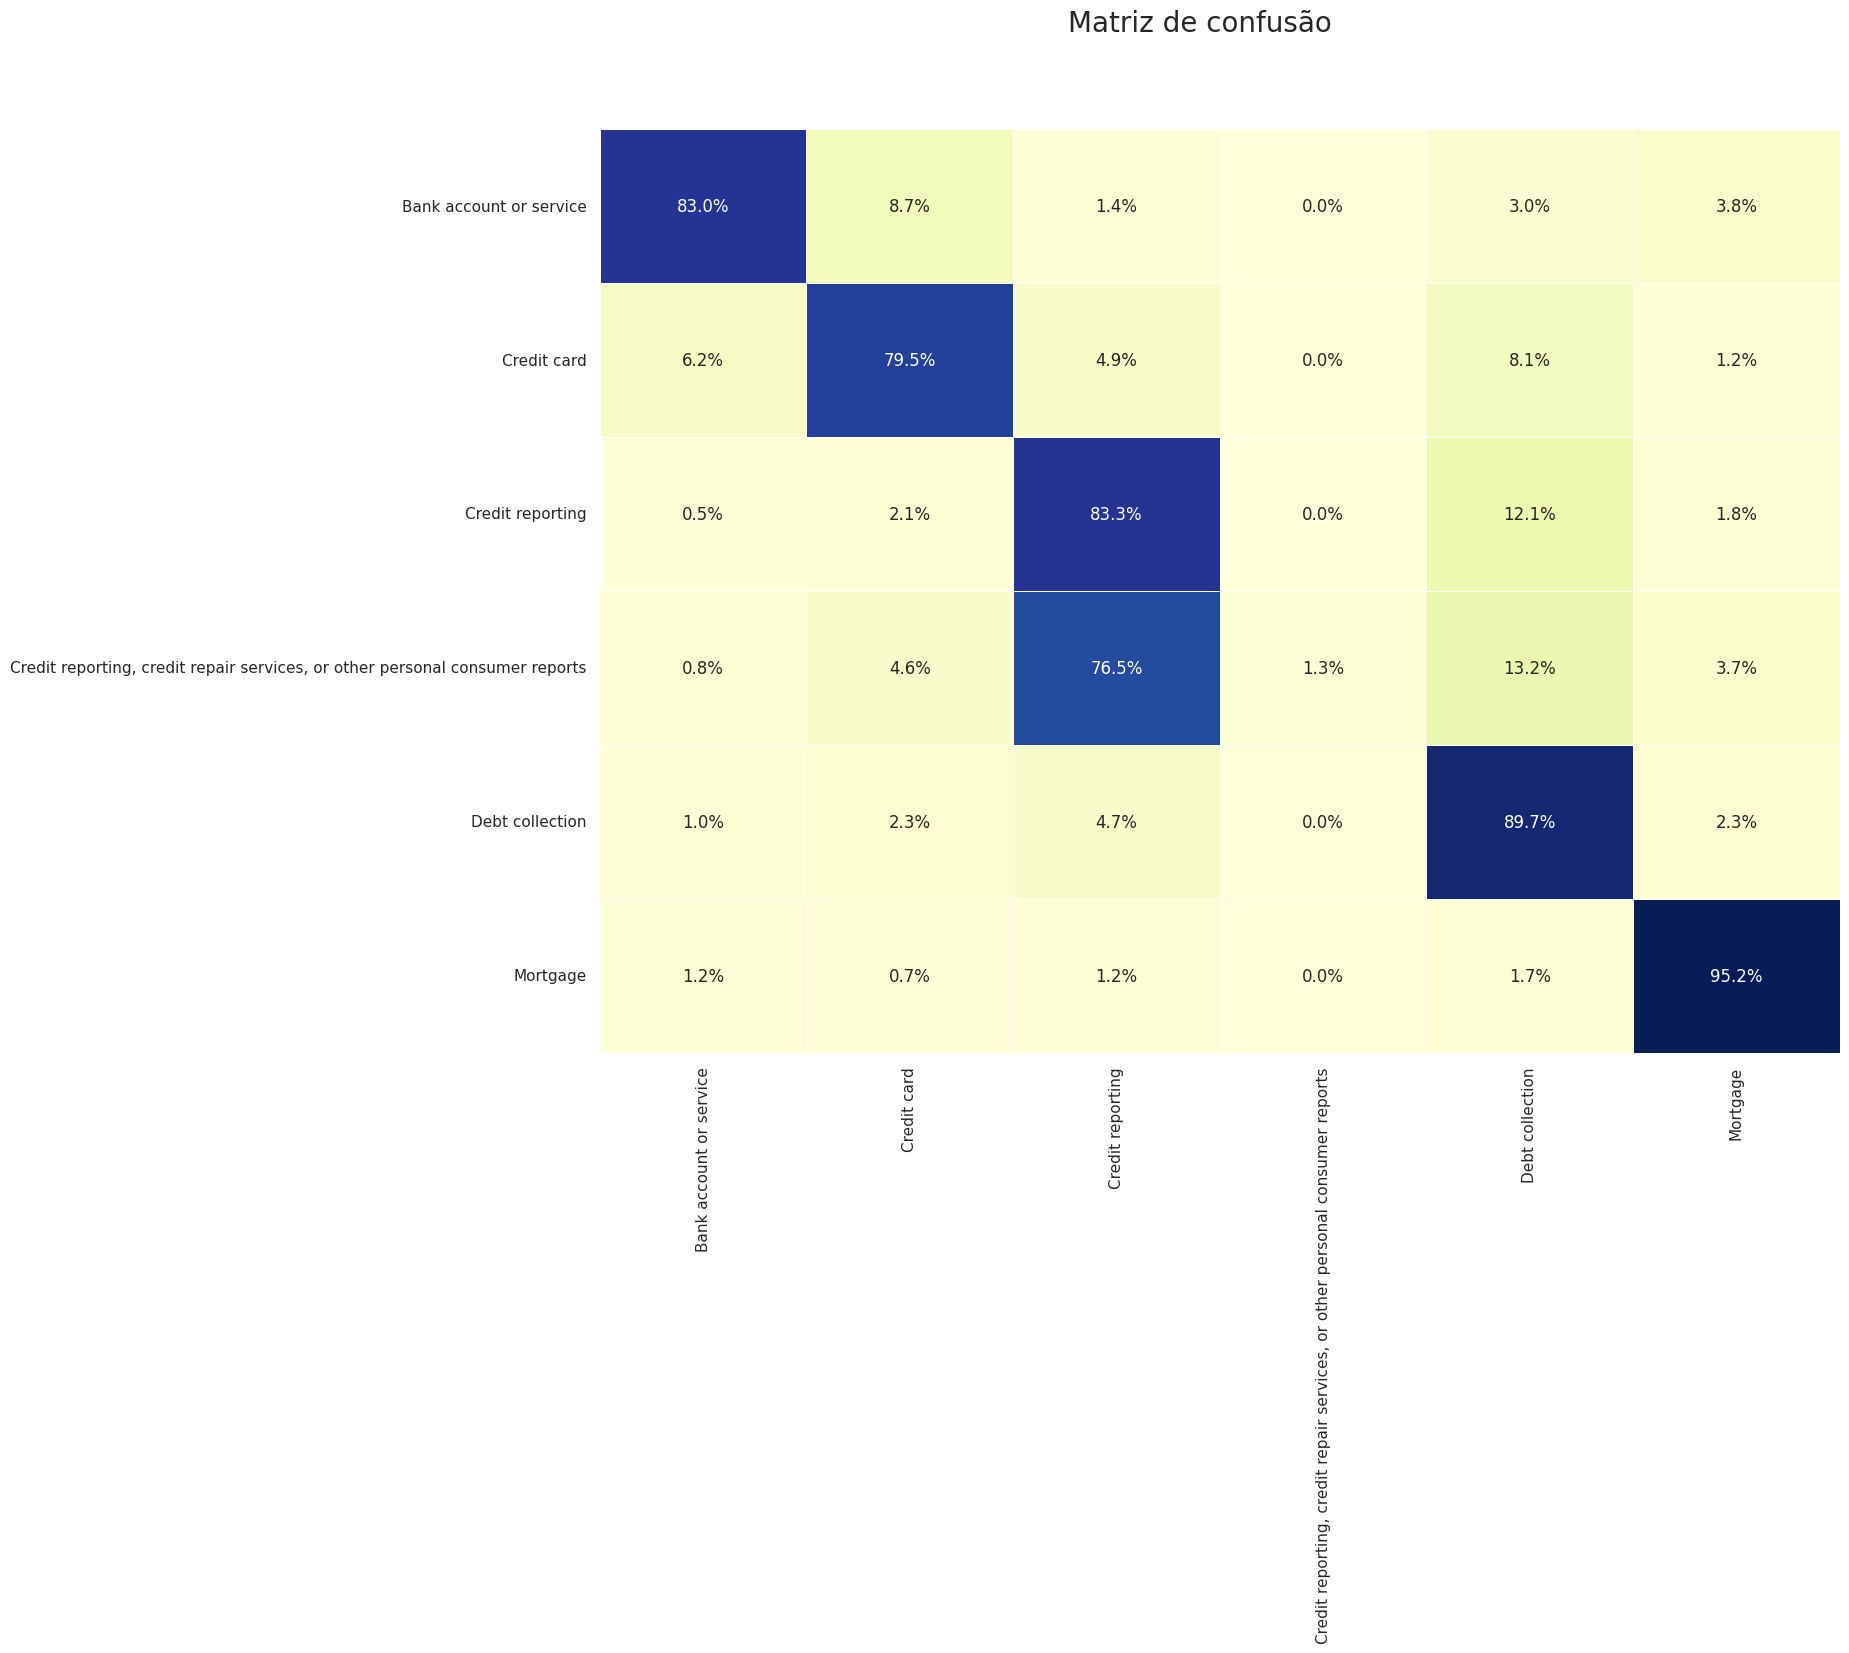

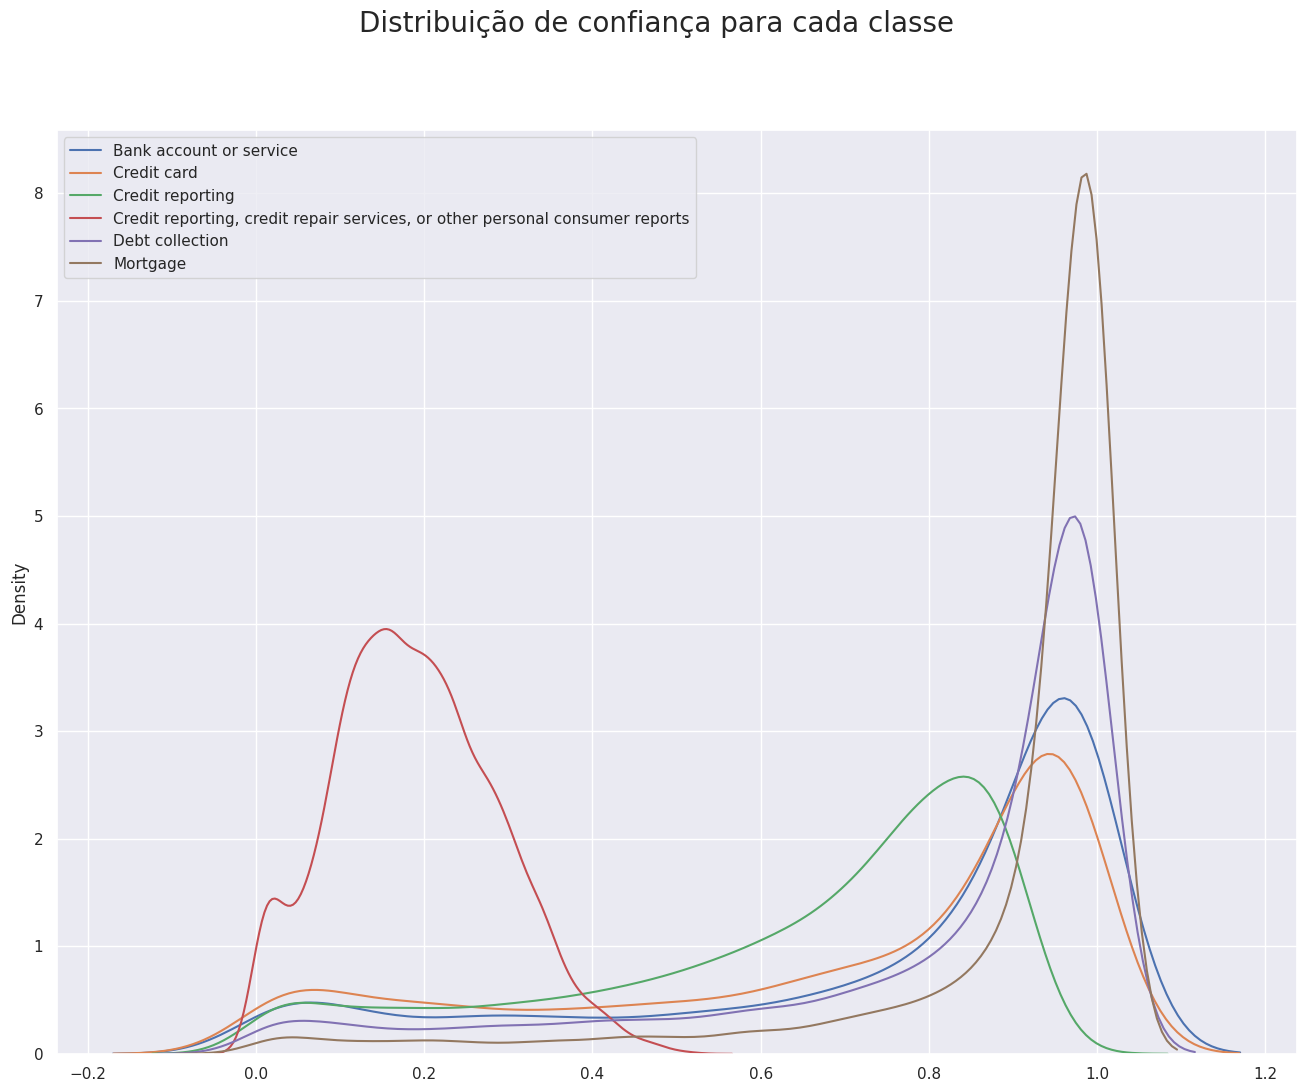

In [33]:

y_pred_probs = model_regularized.predict(x_test)
y_pred_nn = np.argmax(y_pred_probs, axis=1)
evaluate(ye_test, y_pred_nn, y_pred_probs, labels=label_enc.classes_)

**Atividade (1 pt):** avalie os modelos treinados e compare com os resultados anteriores.

In [34]:
#Carregando os weights e definindo funçao para avaliar os modelos

model.load_weights('weights.h5')
model_complex.load_weights('weights_complex.h5')
model_regularized.load_weights('weights_regularized.h5')


def evaluate_and_compare(model, model_name, x_test, ye_test, label_enc):
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    print(f"\nEvaluation for {model_name}:")
    evaluate(ye_test, y_pred, y_pred_probs, labels=label_enc.classes_)

1543/1543 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

Evaluation for Rede Neural Simples:
Accuracy: 1
Accuracy (balanced): 1


<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: User

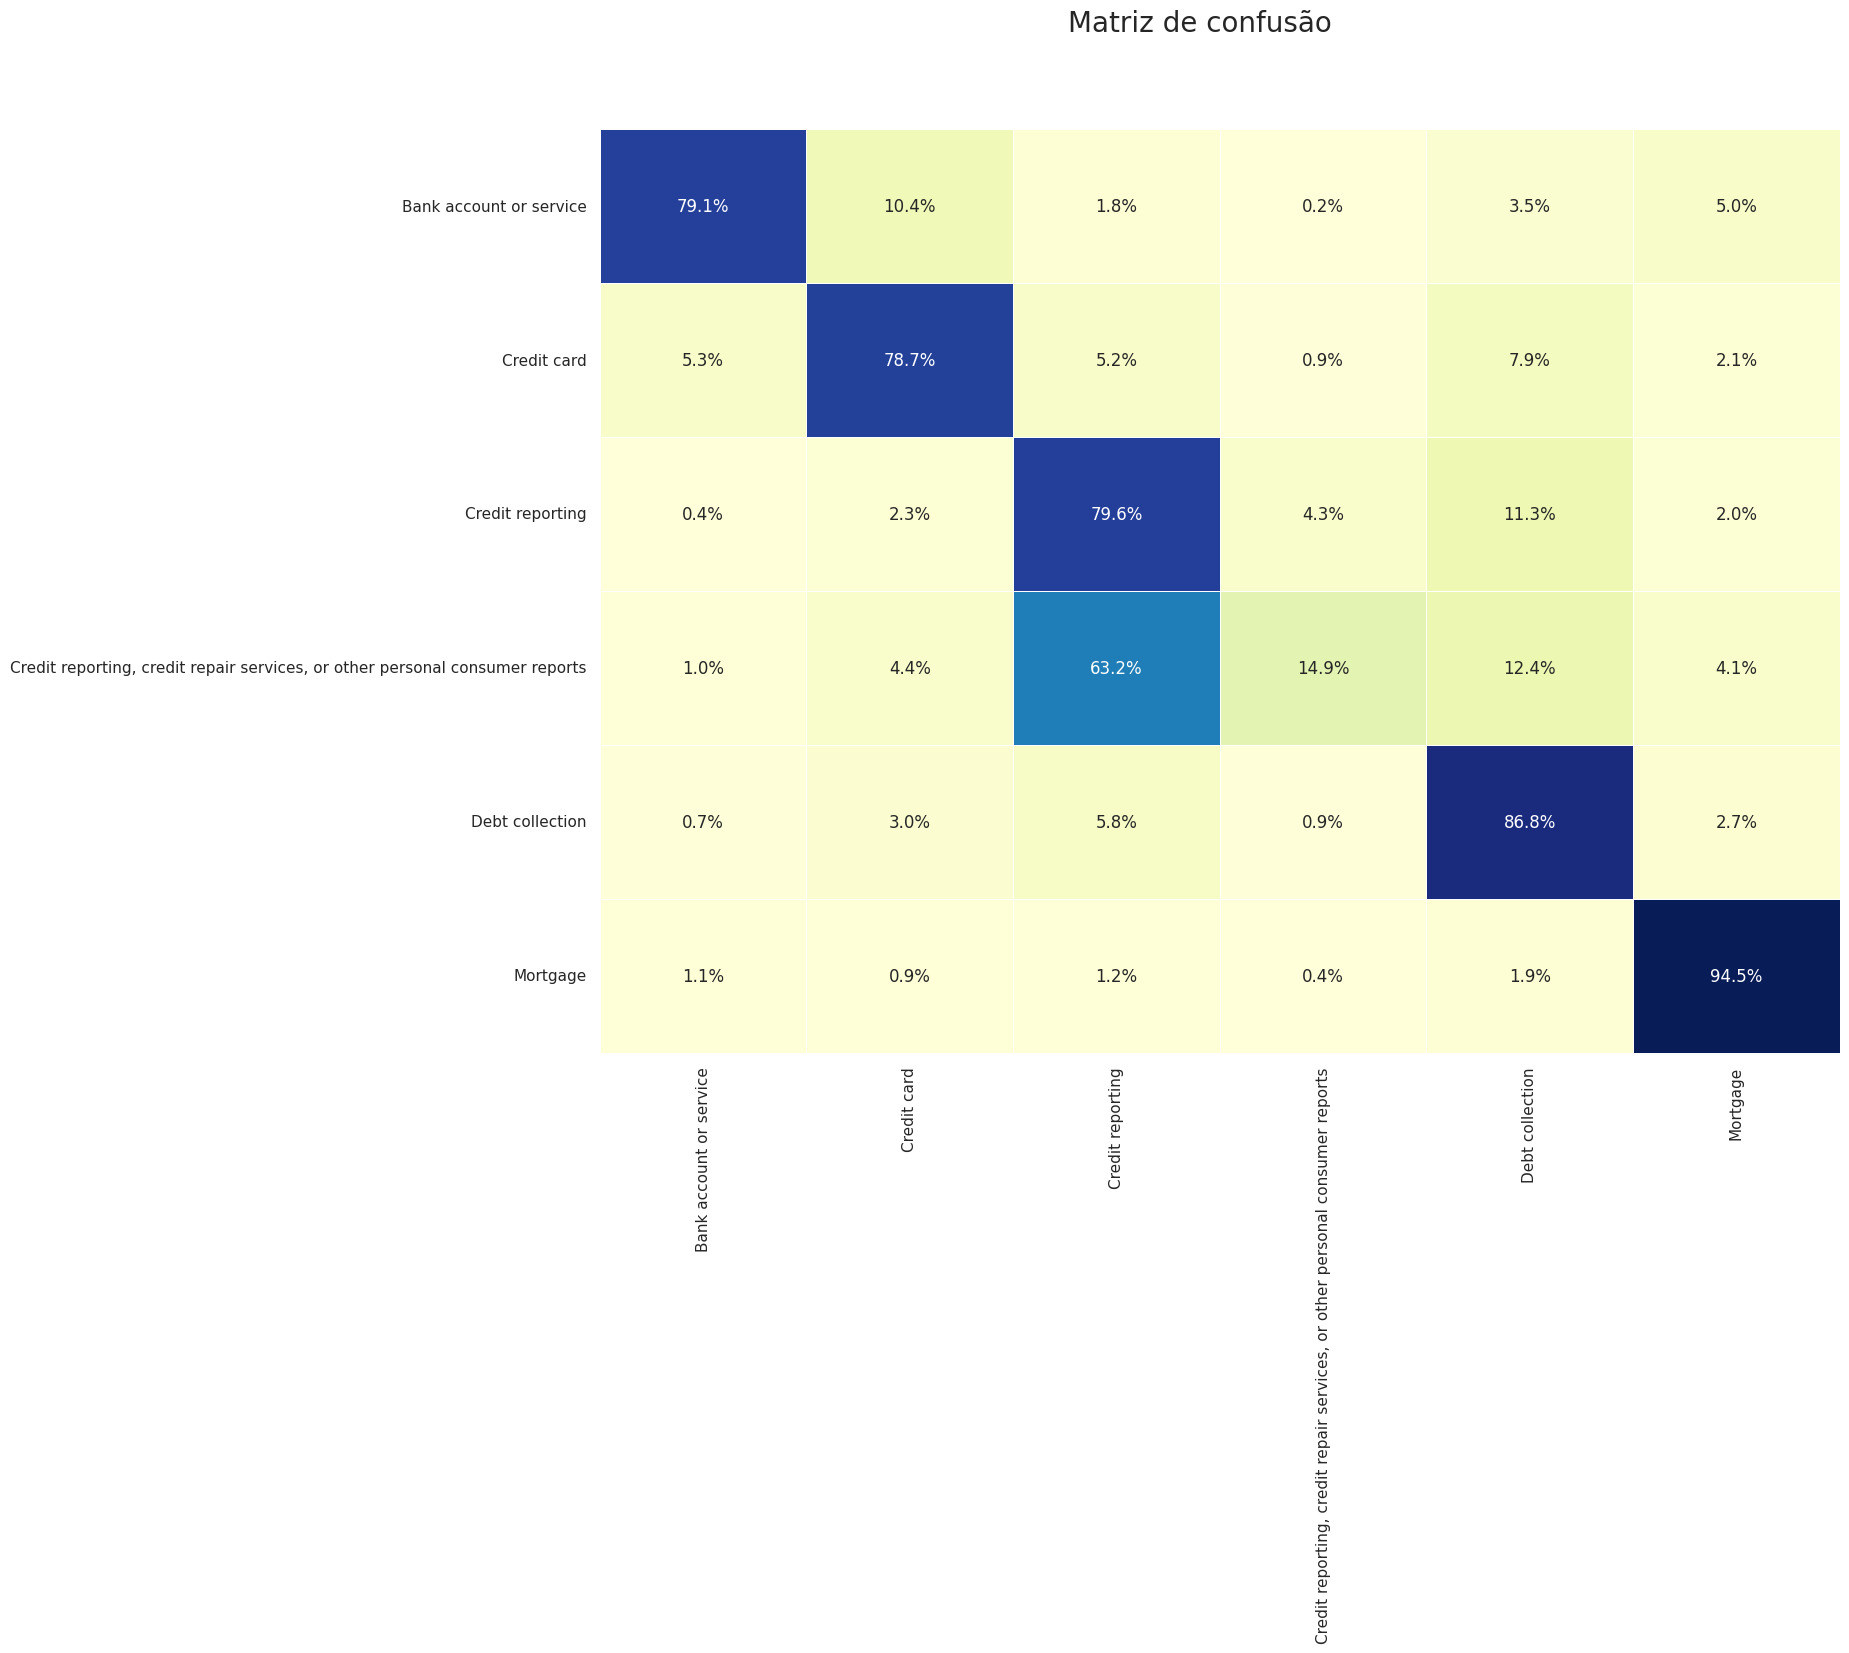

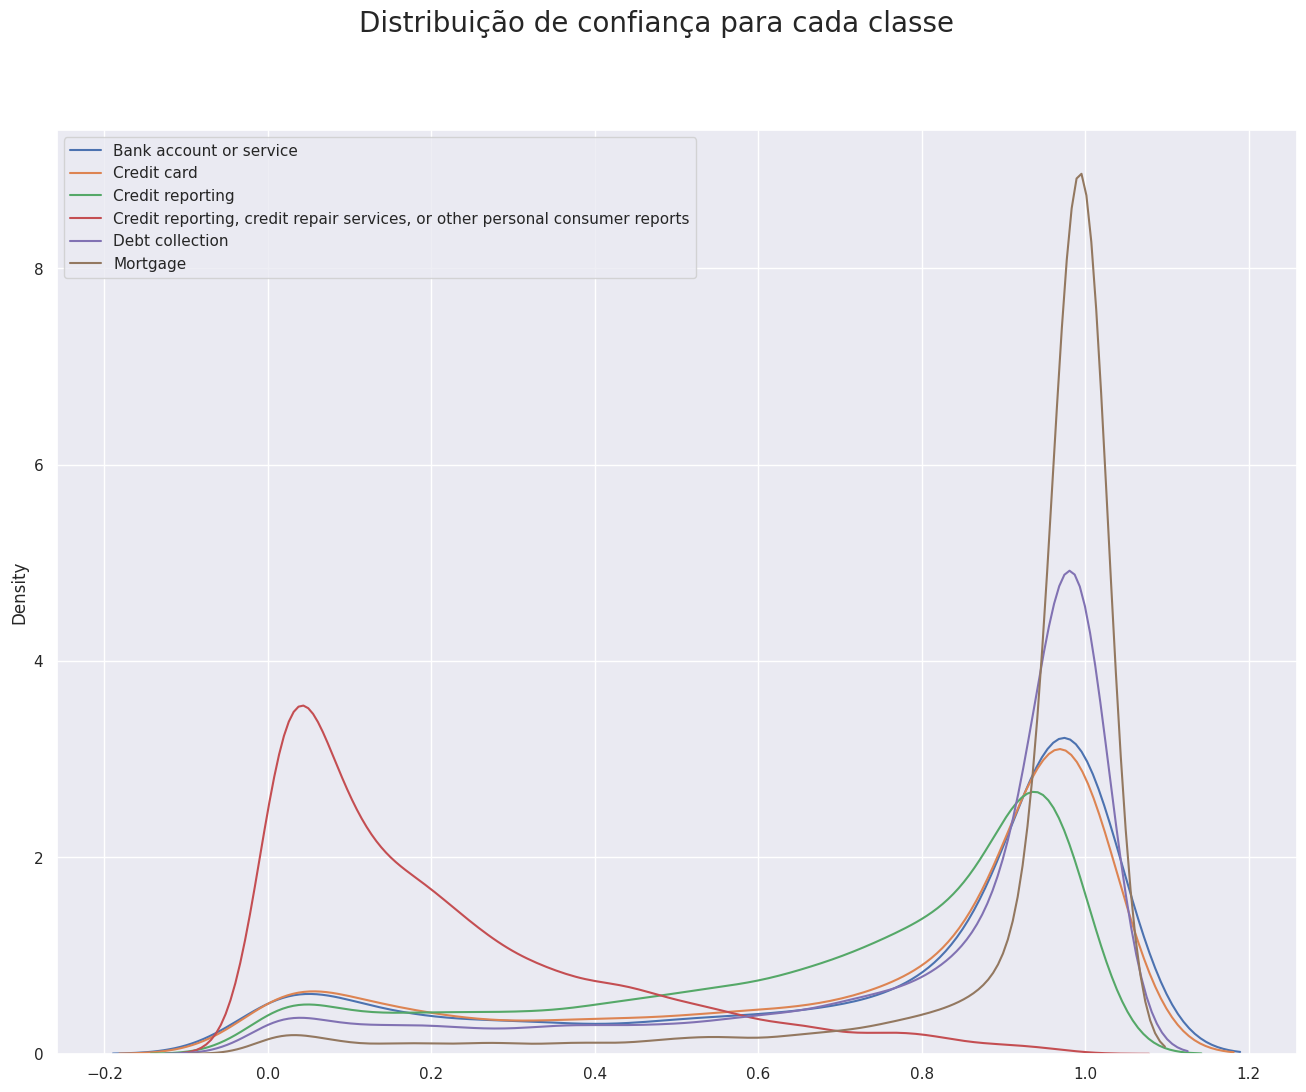

In [35]:
evaluate_and_compare(model, "Rede Neural Simples", x_test, ye_test, label_enc)


1543/1543 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step

Evaluation for Rede Neural Complexa:
Accuracy: 1
Accuracy (balanced): 1


<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: User

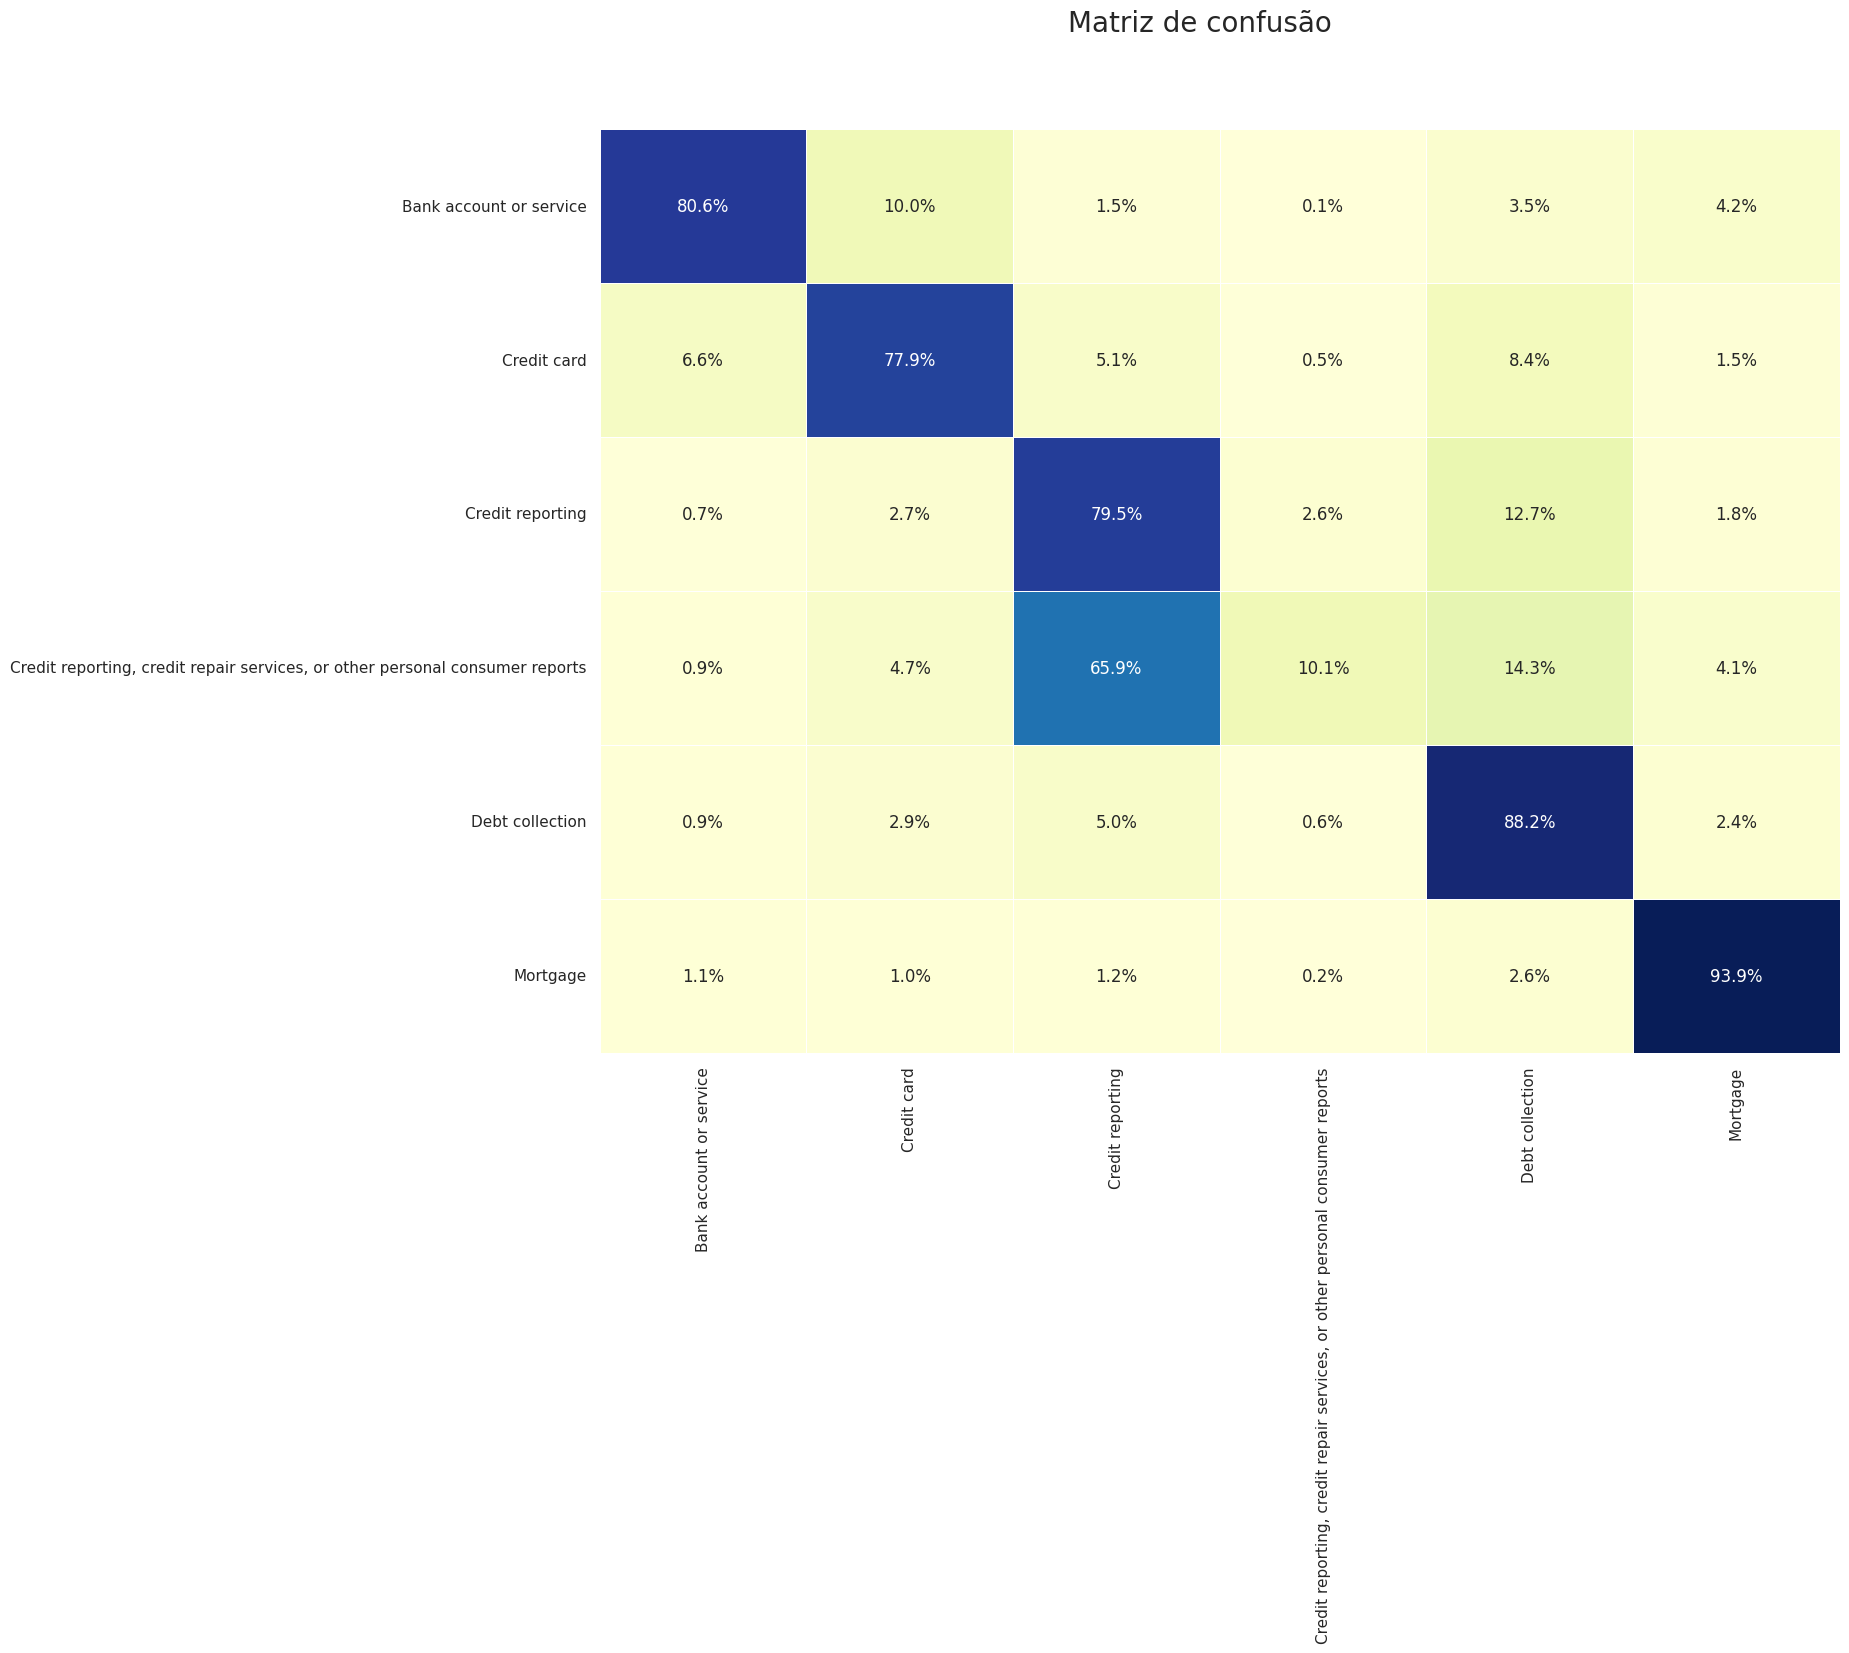

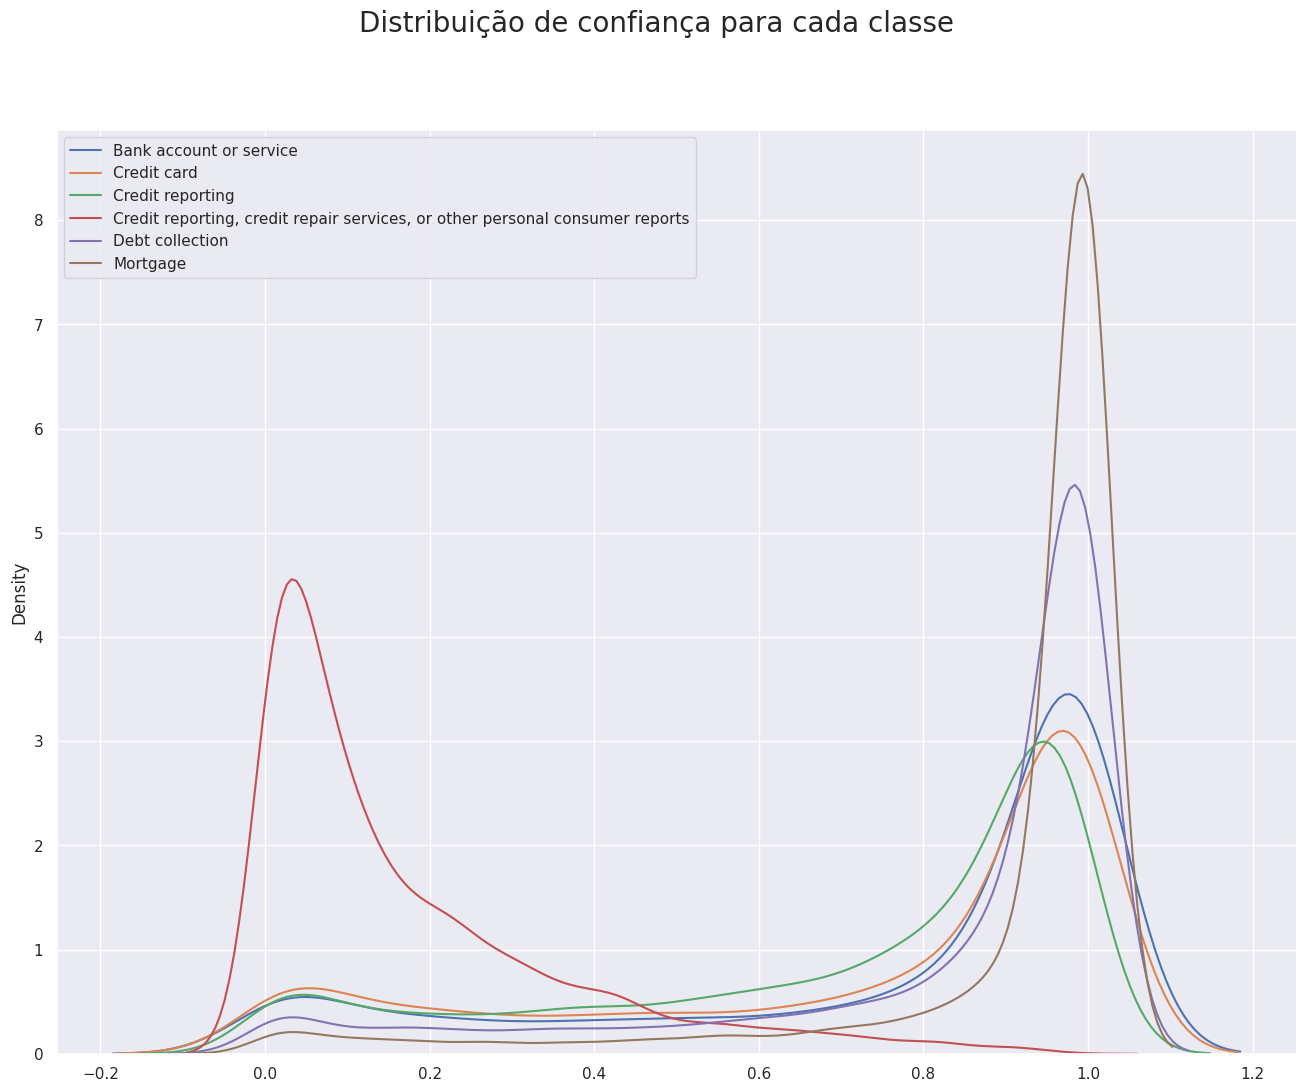

In [36]:
evaluate_and_compare(model_complex, "Rede Neural Complexa", x_test, ye_test, label_enc)


1543/1543 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step

Evaluation for Rede Neural Regularizada:
Accuracy: 1
Accuracy (balanced): 1


<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probabilities[y.ravel() == i][:, i],
<ipython-input-14-e1e4d59ff7a9>:25: User

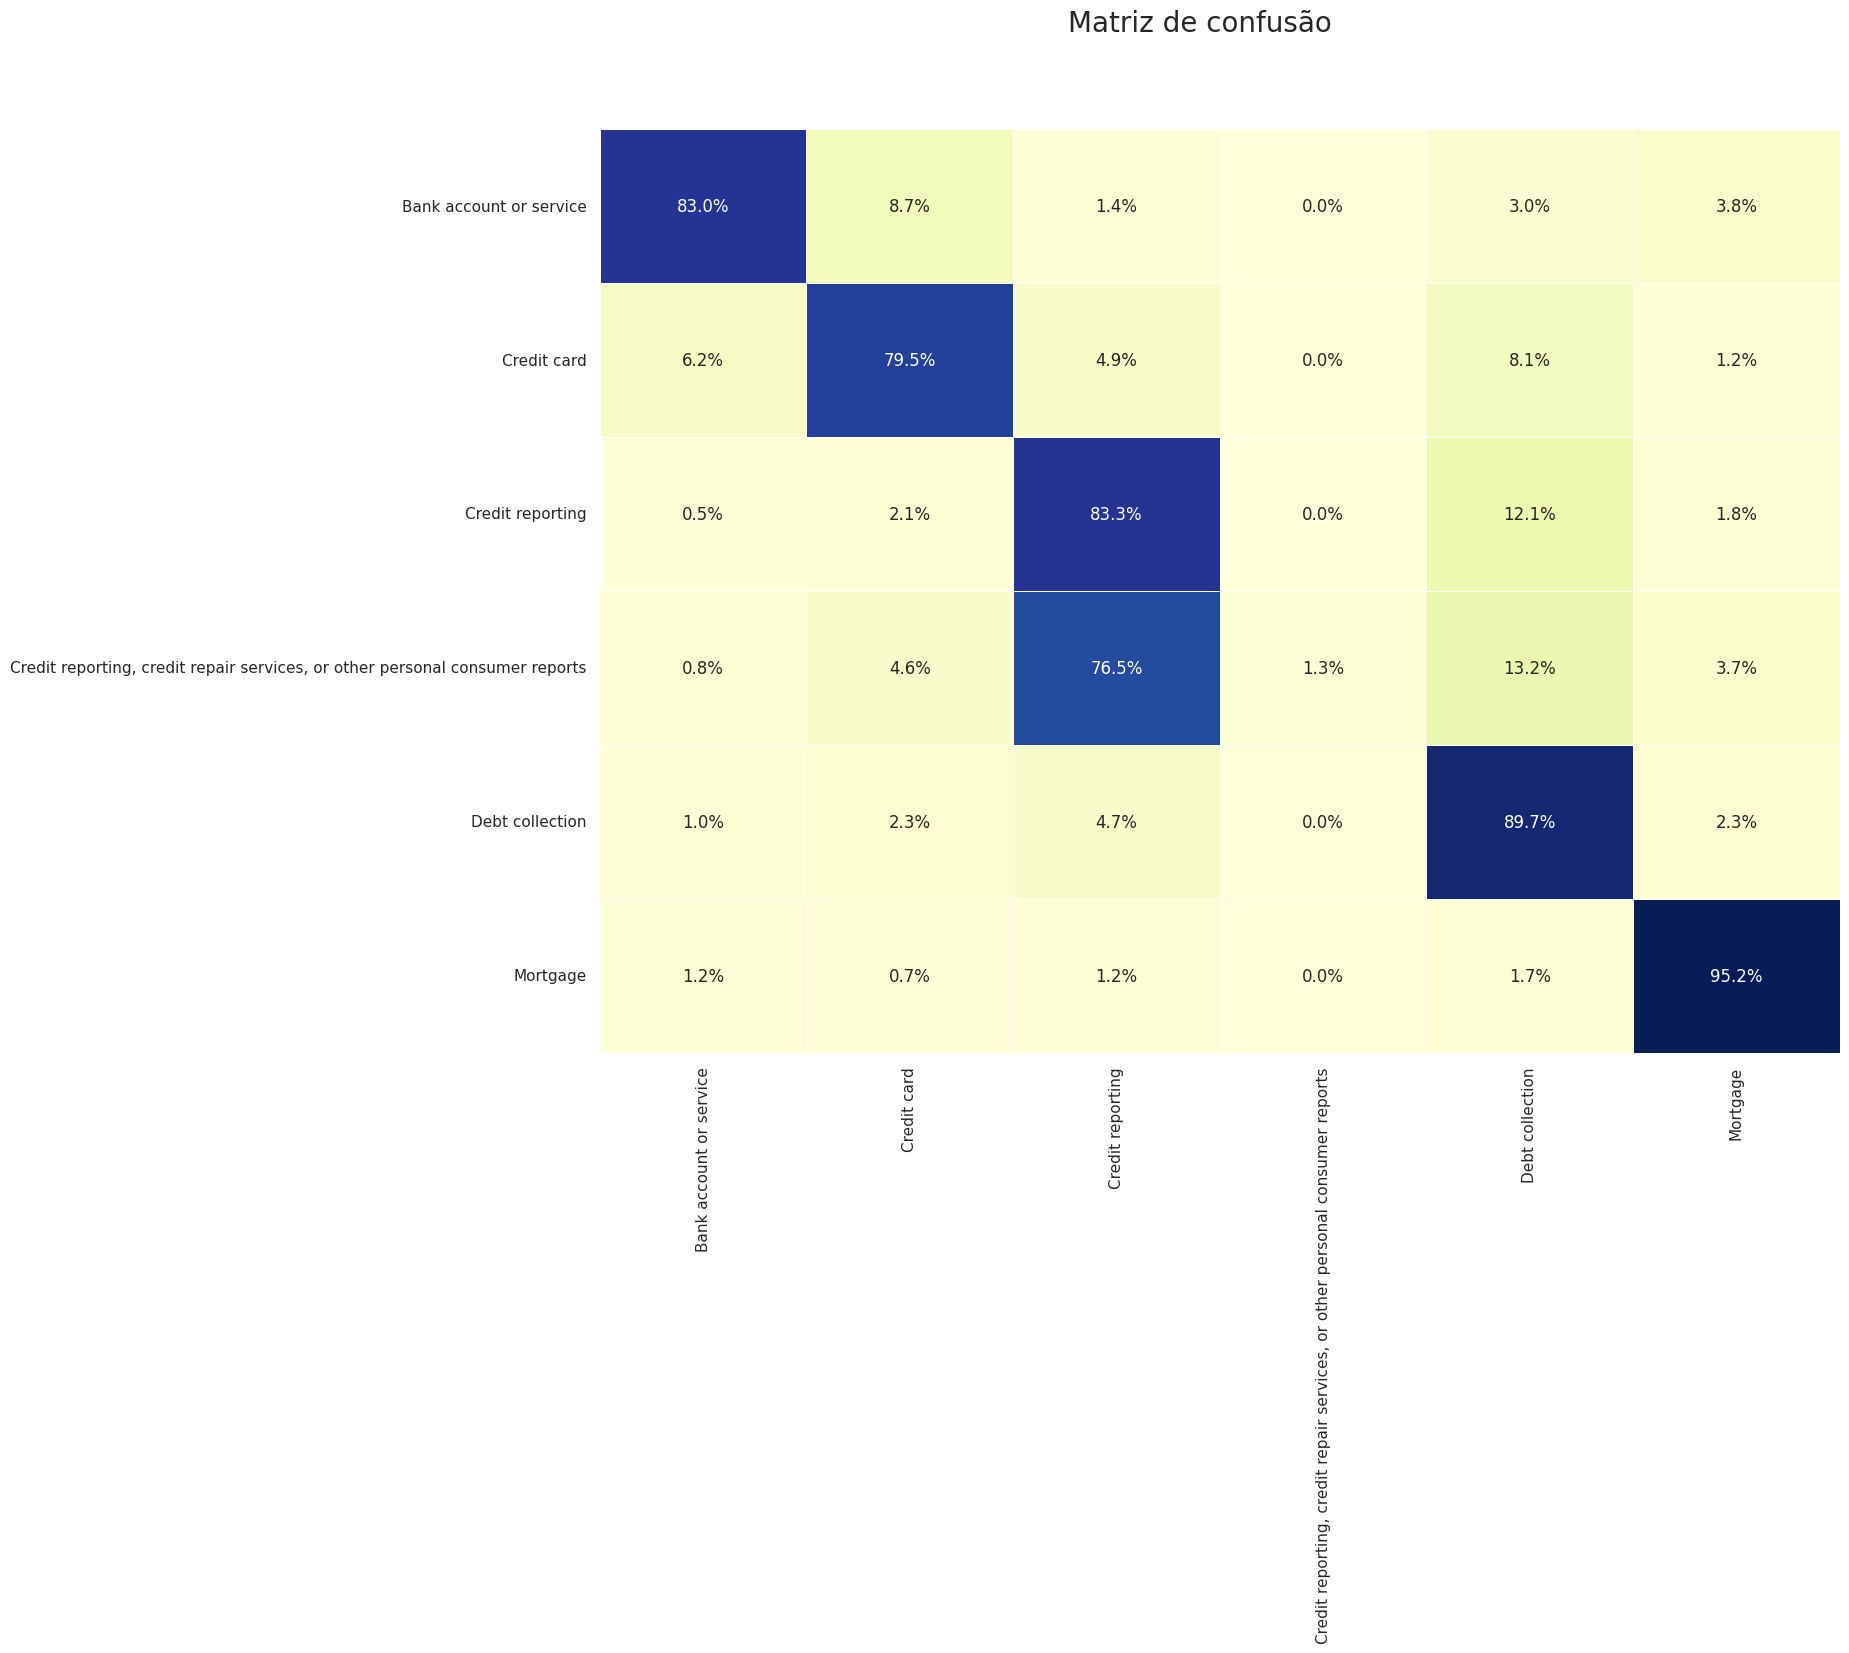

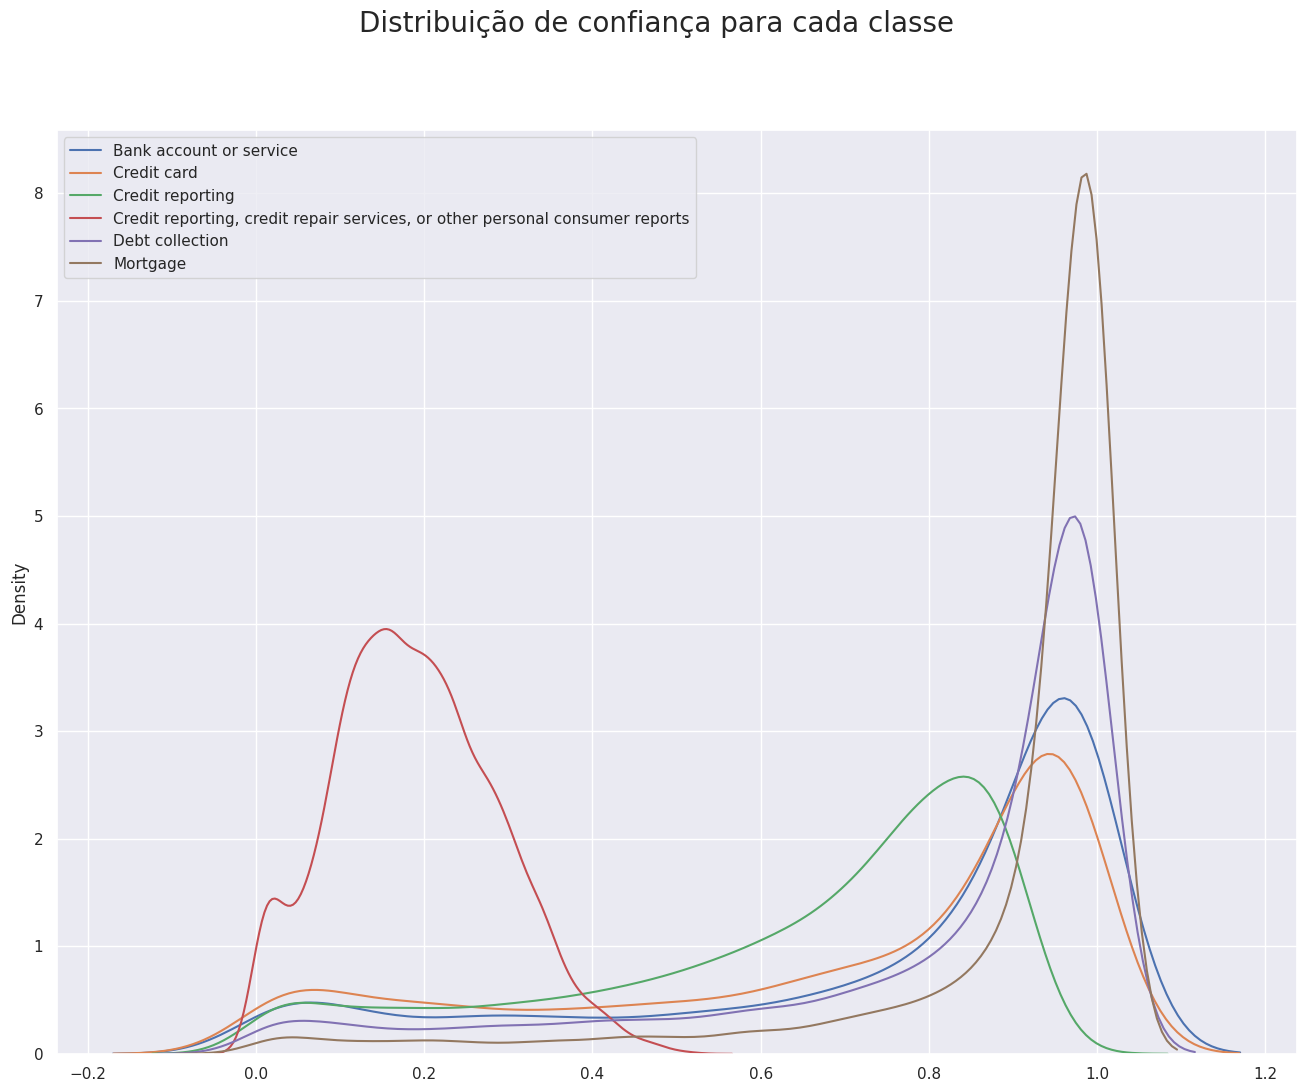

In [37]:
evaluate_and_compare(model_regularized, "Rede Neural Regularizada", x_test, ye_test, label_enc)


Os três modelos de rede neural treinados, simples, complexa e regularizada, apresentaram desempenhos semelhantes, com leves melhorias nas versões mais elaboradas. De modo geral, as classes foram classificadas com alta confiança, especialmente Mortgage e Debt collection, que atingiram as maiores acurácias. No entanto, a classe “Credit reporting, credit repair services...” manteve baixo desempenho em todos os modelos, em termos de acurácia, sendo frequentemente confundida com classes semanticamente próximas. Isso sugere limitações na capacidade dos modelos em distinguir nuances entre categorias semelhantes, indicando a necessidade de aprimoramentos na representação dos dados ou no pré-processamento textual.